# Simple Row-Aggregating Features With Stacking In The Movielens Dataset 

This example illustrates using `pandas`-munging capabilities in estimators building features that draw from several rows. We will use a single table from the [Movielens dataset](https://grouplens.org/datasets/movielens/) (F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS)).

## Loading The Data

In this example, we'll only use the dataset table describing the ratings themselves. I.e., each row is an instance of a single rating given by a specific user to a specific movie.

In [1]:
import os

from sklearn import base
from scipy import stats
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.despine()

import ibex
from ibex.sklearn import model_selection as pd_model_selection
from ibex.sklearn import linear_model as pd_linear_model
from ibex.xgboost import XGBRegressor as PdXGBRegressor

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ratings = pd.read_csv(
    '../movielens_data/ml-100k/u.data', 
    sep='\t', 
    header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'])
features = ['user_id', 'item_id']
ratings = ratings.sample(frac=1)
ratings[features + ['rating']].head()

,user_id,item_id,rating
86771,638,22,5
62532,575,96,5
53876,90,732,5
58171,851,11,5
29495,498,12,4


## dd 

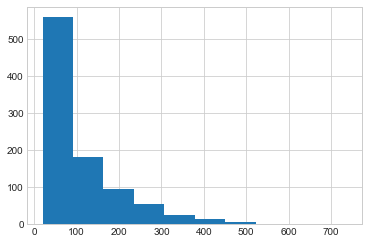

In [3]:
hist(ratings.user_id.groupby(ratings.user_id).count().values);

In [4]:
def sample_group(g):
    p, max_ = 0.5, 200
    num = stats.binom.rvs(min(len(g), max_), p, size=1)[0]
    frac = float(num) / len(g)
    return g.sample(frac=frac)


reduced_ratings = ratings.groupby(ratings.user_id, as_index=False).apply(sample_group)
reduced_ratings.index = reduced_ratings.index.levels[1]
reduced_ratings = reduced_ratings.sample(frac=1)
reduced_ratings.head()

,user_id,item_id,rating,timestamp
19433,189,132,5,893265865
73579,669,97,4,891517238
71580,654,746,3,887864204
13224,122,582,5,879270644
15163,145,234,5,875271948


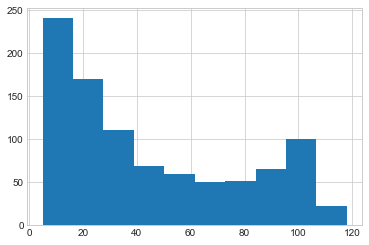

In [5]:
hist(reduced_ratings.user_id.groupby(reduced_ratings.user_id).count().values);

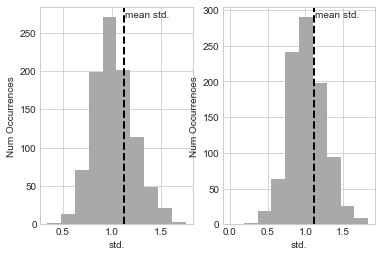

In [6]:
subplot(1, 2, 1)
by_user_std = ratings.rating.groupby(ratings.user_id).std()
axvline(
    ratings.rating.std(), 
    linewidth=2,
    linestyle='dashed',
    color='black');
annotate(
    'mean std.',
    xy=(1.01 * ratings.rating.std(), int(max(hist(by_user_std)[0]))));
hist(
    by_user_std,
    color='darkgrey');
xlabel('std.')
ylabel('Num Occurrences')

subplot(1, 2, 2)
by_user_std = reduced_ratings.rating.groupby(reduced_ratings.user_id).std()
axvline(
    reduced_ratings.rating.std(), 
    linewidth=2,
    linestyle='dashed',
    color='black');
annotate(
    'mean std.',
    xy=(1.01 * reduced_ratings.rating.std(), int(max(hist(by_user_std)[0]))));
hist(
    by_user_std,
    color='darkgrey');
xlabel('std.')
ylabel('Num Occurrences')

## Stacking Using Pandas

Unsuprisingly, the results are even worse than before. Methodically, this is the correct way of building the feature without peeking, and so the CV result should intuitively be weaker.

In [7]:
(user_ratings.rating.sum() - user_ratings.rating) / float(len(user_ratings) - 1)

NameError: name 'user_ratings' is not defined

user_rating_stats = \
    ratings.rating.groupby(ratings.user_id).agg({'user_id_sum': np.sum, 'user_id_count': 'count'})
user_rating_stats.head()

In [8]:
user_ratings = pd.merge(
    ratings[['user_id', 'rating']],
    user_rating_stats,
    left_on='user_id',
    right_index=True,
    how='left')
user_ratings.head()

NameError: name 'user_rating_stats' is not defined

In [9]:
user_ratings[user_ratings.user_id == 1]

NameError: name 'user_ratings' is not defined

In [10]:
user_ratings.user_id_count -= 1
user_ratings['user_id_mean'] = np.where(
    user_ratings.user_id_count == 0,
    -1,
    (user_ratings.user_id_sum - user_ratings.rating) / user_ratings.user_id_count)

NameError: name 'user_ratings' is not defined

In [11]:
user_ratings.head()

NameError: name 'user_ratings' is not defined

In [12]:
user_ratings[user_ratings.user_id == 1]

NameError: name 'user_ratings' is not defined

## Building A Pandas-Munging Stacking Estimator

We'll now use Pandas to build a feature building these features. 

* For each movie, we'll store the mean score & number of occurrences.

* For each user, we'll store the mean score & number of occurrences.

In [10]:
class ScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self._mean = y.mean()
        self._user_id_stats = y.groupby(X.user_id).agg([np.mean, 'count'])
        self._user_id_stats.columns = ['user_id_mean', 'user_id_count']
        return self
        
    def transform(self, X):
        user_ratings = pd.merge(
            X[['user_id']],
            self._user_id_stats,
            left_on='user_id',
            right_index=True,
            how='left')[['user_id_mean', 'user_id_count']]
        user_ratings.user_id_mean = user_ratings.user_id_mean.fillna(self._mean)
        user_ratings.user_id_count = user_ratings.user_id_count.fillna(0)
        return user_ratings
    
f = ScoresAggregator()
f.fit_transform(ratings[features], ratings.rating);

In [52]:
f = ScoresAggregator()

In [53]:
f.fit_transform(ratings[features], ratings.rating);

/usr/local/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


KeyError: 'user_id_mean'

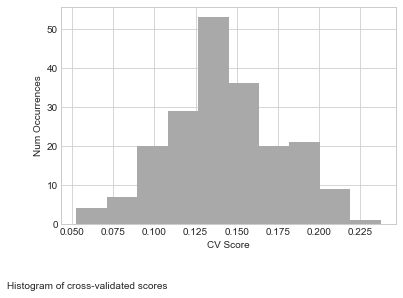

In [11]:
prd = ScoresAggregator() | PdXGBRegressor()
hist(
    pd_model_selection.cross_val_score(prd, ratings[features], ratings.rating, cv=200, n_jobs=-1),
    color='darkgrey');
xlabel('CV Score')
ylabel('Num Occurrences')
figtext(
    0, 
    -0.1, 
    'Histogram of cross-validated scores');

The CV histogram indicates that the results are now positive.

In [17]:
prd.fit(ratings[features], ratings.rating).score(ratings[features], ratings.rating)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


0.15395558467480785

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


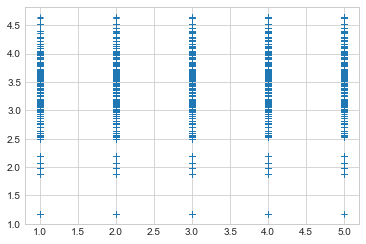

In [18]:
plot(
    ratings.rating,
    prd.fit(ratings[features], ratings.rating).predict(ratings[features]),
    '+');

In [28]:
class StackingScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self.x_columns = X
        self._mean = y.mean()
        self._user_id_stats = y.groupby(X.user_id).agg({'user_id_mean': np.mean, 'user_id_count': 'count'})
        return self
    
    def fit_transform(self, X, y):
        user_rating_stats = \
            y.groupby(X.user_id).agg({'user_id_sum': np.sum, 'user_id_count': 'count'})        
        X_ = pd.concat([X['user_id'], y], axis=1)
        X_.columns = ['user_id', 'rating']
        user_ratings = pd.merge(
            X_,
            user_rating_stats,
            left_on='user_id',
            right_index=True,
            how='left')
        user_ratings.user_id_count -= 1
        user_ratings['user_id_mean'] = np.where(
            user_ratings.user_id_count == 0,
            y.mean(), # Tmp Ami
            (user_ratings.user_id_sum - user_ratings.rating) / user_ratings.user_id_count)
        
        print(
            np.corrcoef(user_ratings.user_id_mean, self.fit(X, y).transform(X).user_id_mean))
        
        self.fit(X, y)
        
        # return self.fit(X, y).transform(X)
        print(user_ratings.columns)
        return user_ratings[['user_id_mean', 'user_id_count']]
        
    def transform(self, X):
        user_ratings = pd.merge(
            X[['user_id']],
            self._user_id_stats,
            left_on='user_id',
            right_index=True,
            how='left')[['user_id_mean', 'user_id_count']]
        user_ratings.user_id_mean = user_ratings.user_id_mean.fillna(self._mean)
        user_ratings.user_id_count = user_ratings.user_id_count.fillna(0)
        return user_ratings
    
from ibex.sklearn.linear_model import LinearRegression as PDLinearRegression
prd = ScoresAggregator() | PDLinearRegression()
stacking_prd = StackingScoresAggregator() | PDLinearRegression()
stacking_prd.fit(reduced_ratings[features], reduced_ratings.rating).score(ratings[features], ratings.rating)

[[ 1.          0.99726679]
 [ 0.99726679  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


0.15005435680043089

In [57]:
scores = pd_model_selection.cross_val_score(prd, reduced_ratings[features], reduced_ratings.rating, cv=2000, n_jobs=-1)

PicklingError: Can't pickle <class '__main__.ScoresAggregator'>: it's not the same object as __main__.ScoresAggregator

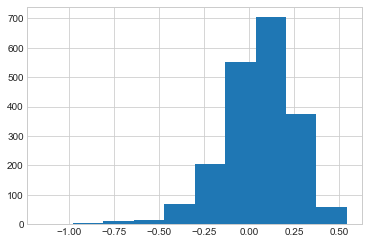

In [22]:
hist(scores);

In [26]:
stacking_scores = pd_model_selection.cross_val_score(stacking_prd, reduced_ratings[features], reduced_ratings.rating, cv=2000, n_jobs=-1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726546]
 [ 0.99726546  1.        ]]
[[ 1.          0.99726351]
 [ 0.99726351  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726367]
 [ 0.99726367  1.        ]]
[[ 1.          0.99726084]
 [ 0.99726084  1.        ]][[ 1.          0.99726771]
 [ 0.99726771  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726353]
 [ 0.99726353  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726564]
 [ 0.99726564  1.        ]][[ 1.         0.9972644]
 [ 0.9972644  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726297]
 [ 0.99726297  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726091]
 [ 0.99726091  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726243]
 [ 0.99726243  1.        ]]
[[ 1.          0.99726724]
 [ 0.99726724  1.        ]]
[[ 1.          0.99726594]
 [ 0.99726594  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726411]
 [ 0.99726411  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726551]
 [ 0.99726551  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726529]
 [ 0.99726529  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726094]
 [ 0.99726094  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726298]
 [ 0.99726298  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726424]
 [ 0.99726424  1.        ]][[ 1.          0.99726282]
 [ 0.99726282  1.        ]]
[[ 1.          0.99726224]
 [ 0.99726224  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726537]
 [ 0.99726537  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726575]
 [ 0.99726575  1.        ]][[ 1.          0.99726426]
 [ 0.99726426  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99725901]
 [ 0.99725901  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99725979]
 [ 0.99725979  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726468]
 [ 0.99726468  1.        ]][[ 1.          0.99726726]
 [ 0.99726726  1.        ]]

[[ 1.          0.99726369]
 [ 0.99726369  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725912]
 [ 0.99725912  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726504]
 [ 0.99726504  1.        ]][[ 1.         0.9972593]
 [ 0.9972593  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726515]
 [ 0.99726515  1.        ]][[ 1.          0.99726354]
 [ 0.99726354  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99727575]
 [ 0.99727575  1.        ]][[ 1.          0.99726259]
 [ 0.99726259  1.        ]][[ 1.          0.99726677]
 [ 0.99726677  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726565]
 [ 0.99726565  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726059]
 [ 0.99726059  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726338]
 [ 0.99726338  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726392]
 [ 0.99726392  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726532]
 [ 0.99726532  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726214]
 [ 0.99726214  1.        ]][[ 1.          0.99726659]
 [ 0.99726659  1.        ]][[ 1.          0.99725856]
 [ 0.99725856  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726812]
 [ 0.99726812  1.        ]]
[[ 1.          0.99726559]
 [ 0.99726559  1.        ]][[ 1.          0.99726537]
 [ 0.99726537  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726248]
 [ 0.99726248  1.        ]][[ 1.         0.9972672]
 [ 0.9972672  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972613]
 [ 0.9972613  1.       ]][[ 1.          0.99726315]
 [ 0.99726315  1.        ]][[ 1.          0.99726124]
 [ 0.99726124  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726692]
 [ 0.99726692  1.        ]]
[[ 1.          0.99726299]
 [ 0.99726299  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726097]
 [ 0.99726097  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99725476]
 [ 0.99725476  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972663]
 [ 0.9972663  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726107]
 [ 0.99726107  1.        ]][[ 1.          0.99726603]
 [ 0.99726603  1.        ]][[ 1.          0.99726712]
 [ 0.99726712  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726606]
 [ 0.99726606  1.        ]][[ 1.          0.99726297]
 [ 0.99726297  1.        ]]
[[ 1.          0.99726329]
 [ 0.99726329  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.         0.9972611]
 [ 0.9972611  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725859]
 [ 0.99725859  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726521]
 [ 0.99726521  1.        ]][[ 1.          0.99725842]
 [ 0.99725842  1.        ]]
[[ 1.          0.99726311]
 [ 0.99726311  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726606]
 [ 0.99726606  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725731]
 [ 0.99725731  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726531]
 [ 0.99726531  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726417]
 [ 0.99726417  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726288]
 [ 0.99726288  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726268]
 [ 0.99726268  1.        ]]
[[ 1.          0.99726682]
 [ 0.99726682  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726529]
 [ 0.99726529  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726504]
 [ 0.99726504  1.        ]][[ 1.         0.9972605]
 [ 0.9972605  1.       ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726579]
 [ 0.99726579  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726485]
 [ 0.99726485  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726373]
 [ 0.99726373  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725996]
 [ 0.99725996  1.        ]]
[[ 1.          0.99726364]
 [ 0.99726364  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972633]
 [ 0.9972633  1.       ]][[ 1.          0.99726666]
 [ 0.99726666  1.        ]]
[[ 1.          0.99726302]
 [ 0.99726302  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726406]
 [ 0.99726406  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726503]
 [ 0.99726503  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726333]
 [ 0.99726333  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972631]
 [ 0.9972631  1.       ]][[ 1.          0.99726199]
 [ 0.99726199  1.        ]]

[[ 1.          0.99726088]
 [ 0.99726088  1.        ]][[ 1.          0.99726491]
 [ 0.99726491  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99726345]
 [ 0.99726345  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726324]
 [ 0.99726324  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726717]
 [ 0.99726717  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726397]
 [ 0.99726397  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972633]
 [ 0.9972633  1.       ]][[ 1.          0.99726404]
 [ 0.99726404  1.        ]]

[[ 1.          0.99726446]
 [ 0.99726446  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726267]
 [ 0.99726267  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726745]
 [ 0.99726745  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726835]
 [ 0.99726835  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726696]
 [ 0.99726696  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726144]
 [ 0.99726144  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726263]
 [ 0.99726263  1.        ]][[ 1.          0.99726378]
 [ 0.99726378  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99726307]
 [ 0.99726307  1.        ]][[ 1.          0.99726395]
 [ 0.99726395  1.        ]]
[[ 1.          0.99726186]
 [ 0.99726186  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726356]
 [ 0.99726356  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99725675]
 [ 0.99725675  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726503]
 [ 0.99726503  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726294]
 [ 0.99726294  1.        ]][[ 1.          0.99726269]
 [ 0.99726269  1.        ]]
[[ 1.          0.99726726]
 [ 0.99726726  1.        ]][[ 1.          0.99726375]
 [ 0.99726375  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726529]
 [ 0.99726529  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726683]
 [ 0.99726683  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726606]
 [ 0.99726606  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726047]
 [ 0.99726047  1.        ]][[ 1.         0.9972626]
 [ 0.9972626  1.       ]][[ 1.         0.9972655]
 [ 0.9972655  1.       ]][[ 1.          0.99725915]
 [ 0.99725915  1.        ]][[ 1.          0.99726543]
 [ 0.99726543  1.        ]]




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726225]
 [ 0.99726225  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726026]
 [ 0.99726026  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ 

[[ 1.          0.99726651]
 [ 0.99726651  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726162]
 [ 0.99726162  1.        ]][[ 1.          0.99726588]
 [ 0.99726588  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972641]
 [ 0.9972641  1.       ]][[ 1.         0.9972614]
 [ 0.9972614  1.       ]]


[[ 1.          0.99726477]
 [ 0.99726477  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726576]
 [ 0.99726576  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726293]
 [ 0.99726293  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/loc

[[ 1.          0.99726051]
 [ 0.99726051  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726454]
 [ 0.99726454  1.        ]][[ 1.          0.99726434]
 [ 0.99726434  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726712]
 [ 0.99726712  1.        ]]


[[ 1.          0.99726258]
 [ 0.99726258  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726608]
 [ 0.99726608  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726262]
 [ 0.99726262  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725862]
 [ 0.99725862  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726367]
 [ 0.99726367  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726602]
 [ 0.99726602  1.        ]][[ 1.         0.9972641]
 [ 0.9972641  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.         0.9972615]
 [ 0.9972615  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99725935]
 [ 0.99725935  1.        ]][[ 1.          0.99726381]
 [ 0.99726381  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726428]
 [ 0.99726428  1.        ]]
[[ 1.          0.99725794]
 [ 0.99725794  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ 

[[ 1.          0.99726554]
 [ 0.99726554  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972651]
 [ 0.9972651  1.       ]][[ 1.          0.99726279]
 [ 0.99726279  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




[[ 1.          0.99726443]
 [ 0.99726443  1.        ]][[ 1.          0.99726457]
 [ 0.99726457  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726563]
 [ 0.99726563  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726467]
 [ 0.99726467  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726421]
 [ 0.99726421  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726419]
 [ 0.99726419  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726349]
 [ 0.99726349  1.        ]][[ 1.          0.99726755]
 [ 0.99726755  1.        ]]

[[ 1.          0.99726611]
 [ 0.99726611  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726462]
 [ 0.99726462  1.        ]][[ 1.          0.99726492]
 [ 0.99726492  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726132]
 [ 0.99726132  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726593]
 [ 0.99726593  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726354]
 [ 0.99726354  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726294]
 [ 0.99726294  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726347]
 [ 0.99726347  1.        ]][[ 1.          0.99726871]
 [ 0.99726871  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726604]
 [ 0.99726604  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726122]
 [ 0.99726122  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726401]
 [ 0.99726401  1.        ]]
[[ 1.          0.99726642]
 [ 0.99726642  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.         0.9972682]
 [ 0.9972682  1.       ]]
[[ 1.         0.9972657]
 [ 0.9972657  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726456]
 [ 0.99726456  1.        ]][[ 1.          0.99726618]
 [ 0.99726618  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




[[ 1.          0.99726483]
 [ 0.99726483  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726259]
 [ 0.99726259  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726321]
 [ 0.99726321  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726501]
 [ 0.99726501  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726304]
 [ 0.99726304  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726412]
 [ 0.99726412  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726139]
 [ 0.99726139  1.        ]][[ 1.          0.99726565]
 [ 0.99726565  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726541]
 [ 0.99726541  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726497]
 [ 0.99726497  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.        0.997267]
 [ 0.997267  1.      ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726076]
 [ 0.99726076  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726327]
 [ 0.99726327  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726178]
 [ 0.99726178  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726266]
 [ 0.99726266  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726575]
 [ 0.99726575  1.        ]][[ 1.          0.99726408]
 [ 0.99726408  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726241]
 [ 0.99726241  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726234]
 [ 0.99726234  1.        ]][[ 1.        0.997266]
 [ 0.997266  1.      ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726526]
 [ 0.99726526  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726643]
 [ 0.99726643  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726442]
 [ 0.99726442  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726306]
 [ 0.99726306  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




[[ 1.          0.99726187]
 [ 0.99726187  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726309]
 [ 0.99726309  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99725701]
 [ 0.99725701  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726419]
 [ 0.99726419  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726534]
 [ 0.99726534  1.        ]][[ 1.          0.99726841]
 [ 0.99726841  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726514]
 [ 0.99726514  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99727103]
 [ 0.99727103  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726311]
 [ 0.99726311  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726466]
 [ 0.99726466  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726761]
 [ 0.99726761  1.        ]]
[[ 1.         0.9972639]
 [ 0.9972639  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.         0.9972671]
 [ 0.9972671  1.       ]]
[[ 1.          0.99725929]
 [ 0.99725929  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726193]
 [ 0.99726193  1.        ]][[ 1.         0.9972645]
 [ 0.9972645  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726664]
 [ 0.99726664  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726377]
 [ 0.99726377  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726446]
 [ 0.99726446  1.        ]][[ 1.          0.99726553]
 [ 0.99726553  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726459]
 [ 0.99726459  1.        ]][[ 1.        0.997264]
 [ 0.997264  1.      ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726493]
 [ 0.99726493  1.        ]][[ 1.          0.99726609]
 [ 0.99726609  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725803]
 [ 0.99725803  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726383]
 [ 0.99726383  1.        ]]
[[ 1.          0.99726328]
 [ 0.99726328  1.        ]][[ 1.         0.9972587]
 [ 0.9972587  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726737]
 [ 0.99726737  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726426]
 [ 0.99726426  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726394]
 [ 0.99726394  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726473]
 [ 0.99726473  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99725808]
 [ 0.99725808  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726503]
 [ 0.99726503  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726932]
 [ 0.99726932  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726278]
 [ 0.99726278  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972621]
 [ 0.9972621  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99727587]
 [ 0.99727587  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99727136]
 [ 0.99727136  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726491]
 [ 0.99726491  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726194]
 [ 0.99726194  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726348]
 [ 0.99726348  1.        ]]
[[ 1.         0.9972581]
 [ 0.9972581  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726265]
 [ 0.99726265  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726296]
 [ 0.99726296  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726289]
 [ 0.99726289  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726512]
 [ 0.99726512  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726527]
 [ 0.99726527  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726511]
 [ 0.99726511  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726629]
 [ 0.99726629  1.        ]][[ 1.          0.99725977]
 [ 0.99725977  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726401]
 [ 0.99726401  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726183]
 [ 0.99726183  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726311]
 [ 0.99726311  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726276]
 [ 0.99726276  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726333]
 [ 0.99726333  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726556]
 [ 0.99726556  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726687]
 [ 0.99726687  1.        ]][[ 1.          0.99724794]
 [ 0.99724794  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.          0.99726464]
 [ 0.99726464  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726537]
 [ 0.99726537  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726589]
 [ 0.99726589  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726568]
 [ 0.99726568  1.        ]]
[[ 1.          0.99726558]
 [ 0.99726558  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726366]
 [ 0.99726366  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726162]
 [ 0.99726162  1.        ]][[ 1.          0.99726157]
 [ 0.99726157  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99726276]
 [ 0.99726276  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726228]
 [ 0.99726228  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726072]
 [ 0.99726072  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726648]
 [ 0.99726648  1.        ]][[ 1.          0.99726398]
 [ 0.99726398  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726331]
 [ 0.99726331  1.        ]]
[[ 1.          0.99726236]
 [ 0.99726236  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726016]
 [ 0.99726016  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726602]
 [ 0.99726602  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726462]
 [ 0.99726462  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726445]
 [ 0.99726445  1.        ]]
[[ 1.          0.99726556]
 [ 0.99726556  1.        ]][[ 1.          0.99726643]
 [ 0.99726643  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726373]
 [ 0.99726373  1.        ]]
[[ 1.          0.99726731]
 [ 0.99726731  1.        ]]
[[ 1.         0.9972648]
 [ 0.9972648  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726136]
 [ 0.99726136  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726598]
 [ 0.99726598  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726455]
 [ 0.99726455  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726592]
 [ 0.99726592  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726393]
 [ 0.99726393  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726176]
 [ 0.99726176  1.        ]]
[[ 1.          0.99725914]
 [ 0.99725914  1.        ]][[ 1.          0.99726171]
 [ 0.99726171  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.          0.99726329]
 [ 0.99726329  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726588]
 [ 0.99726588  1.        ]][[ 1.          0.99726064]
 [ 0.99726064  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972643]
 [ 0.9972643  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726388]
 [ 0.99726388  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726133]
 [ 0.99726133  1.        ]][[ 1.          0.99726891]
 [ 0.99726891  1.        ]][[ 1.          0.99726598]
 [ 0.99726598  1.        ]]


[[ 1.          0.99725817]
 [ 0.99725817  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726468]
 [ 0.99726468  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726219]
 [ 0.99726219  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972611]
 [ 0.9972611  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726609]
 [ 0.99726609  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726415]
 [ 0.99726415  1.        ]][[ 1.          0.99726513]
 [ 0.99726513  1.        ]]
[[ 1.          0.99726347]
 [ 0.99726347  1.        ]]

[[ 1.          0.99726285]
 [ 0.99726285  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.         0.9972615]
 [ 0.9972615  1.       ]][[ 1.          0.99726242]
 [ 0.99726242  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726285]
 [ 0.99726285  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726578]
 [ 0.99726578  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726436]
 [ 0.99726436  1.        ]][[ 1.          0.99725317]
 [ 0.99725317  1.        ]][[ 1.          0.99726416]
 [ 0.99726416  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726433]
 [ 0.99726433  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972664]
 [ 0.9972664  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726026]
 [ 0.99726026  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726609]
 [ 0.99726609  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726808]
 [ 0.99726808  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726239]
 [ 0.99726239  1.        ]][[ 1.          0.99726763]
 [ 0.99726763  1.        ]][[ 1.          0.99726461]
 [ 0.99726461  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726413]
 [ 0.99726413  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726692]
 [ 0.99726692  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726472]
 [ 0.99726472  1.        ]][[ 1.          0.99726195]
 [ 0.99726195  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972649]
 [ 0.9972649  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726457]
 [ 0.99726457  1.        ]][[ 1.        0.997264]
 [ 0.997264  1.      ]]

[[ 1.         0.9972643]
 [ 0.9972643  1.       ]][[ 1.          0.99726461]
 [ 0.99726461  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726277]
 [ 0.99726277  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726081]
 [ 0.99726081  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726666]
 [ 0.99726666  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726373]
 [ 0.99726373  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972636]
 [ 0.9972636  1.       ]]
[[ 1.          0.99726606]
 [ 0.99726606  1.        ]][[ 1.          0.99726518]
 [ 0.99726518  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726787]
 [ 0.99726787  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726534]
 [ 0.99726534  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726098]
 [ 0.99726098  1.        ]][[ 1.          0.99726421]
 [ 0.99726421  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726539]
 [ 0.99726539  1.        ]]
[[ 1.          0.99726829]
 [ 0.99726829  1.        ]][[ 1.          0.99726319]
 [ 0.99726319  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.          0.99726612]
 [ 0.99726612  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972627]
 [ 0.9972627  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726403]
 [ 0.99726403  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726615]
 [ 0.99726615  1.        ]][[ 1.          0.99726362]
 [ 0.99726362  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726498]
 [ 0.99726498  1.        ]]
[[ 1.          0.99726575]
 [ 0.99726575  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726513]
 [ 0.99726513  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726461]
 [ 0.99726461  1.        ]][[ 1.         0.9972632]
 [ 0.9972632  1.       ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726419]
 [ 0.99726419  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726225]
 [ 0.99726225  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726713]
 [ 0.99726713  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726736]
 [ 0.99726736  1.        ]][[ 1.          0.99726059]
 [ 0.99726059  1.        ]][[ 1.          0.99726163]
 [ 0.99726163  1.        ]]

[[ 1.          0.99726799]
 [ 0.99726799  1.        ]][[ 1.          0.99726402]
 [ 0.99726402  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726639]
 [ 0.99726639  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726488]
 [ 0.99726488  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972627]
 [ 0.9972627  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726422]
 [ 0.99726422  1.        ]][[ 1.          0.99726108]
 [ 0.99726108  1.        ]][[ 1.          0.99726263]
 [ 0.99726263  1.        ]][[ 1.          0.99726331]
 [ 0.99726331  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726401]
 [ 0.99726401  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726414]
 [ 0.99726414  1.        ]][[ 1.          0.99726362]
 [ 0.99726362  1.        ]]
[[ 1.          0.99726558]
 [ 0.99726558  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726938]
 [ 0.99726938  1.        ]][[ 1.          0.99726537]
 [ 0.99726537  1.        ]]

[[ 1.          0.99726384]
 [ 0.99726384  1.        ]][[ 1.         0.9972639]
 [ 0.9972639  1.       ]][[ 1.          0.99726322]
 [ 0.99726322  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.         0.9972638]
 [ 0.9972638  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726142]
 [ 0.99726142  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726336]
 [ 0.99726336  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726563]
 [ 0.99726563  1.        ]]
[[ 1.          0.99725726]
 [ 0.99725726  1.        ]][[ 1.          0.99726412]
 [ 0.99726412  1.        ]]

[[ 1.          0.99726227]
 [ 0.99726227  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726328]
 [ 0.99726328  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99727056]
 [ 0.99727056  1.        ]][[ 1.         0.9972654]
 [ 0.9972654  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726406]
 [ 0.99726406  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726452]
 [ 0.99726452  1.        ]][[ 1.          0.99726552]
 [ 0.99726552  1.        ]]
[[ 1.          0.99726303]
 [ 0.99726303  1.        ]]
[[ 1.          0.99725864]
 [ 0.99725864  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726651]
 [ 0.99726651  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726508]
 [ 0.99726508  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99725947]
 [ 0.99725947  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726303]
 [ 0.99726303  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726051]
 [ 0.99726051  1.        ]][[ 1.          0.99726231]
 [ 0.99726231  1.        ]][[ 1.          0.99726275]
 [ 0.99726275  1.        ]][[ 1.          0.99726529]
 [ 0.99726529  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':





[[ 1.          0.99726209]
 [ 0.99726209  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726448]
 [ 0.99726448  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726532]
 [ 0.99726532  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726625]
 [ 0.99726625  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726634]
 [ 0.99726634  1.        ]]
[[ 1.          0.99726503]
 [ 0.99726503  1.        ]]
[[ 1.          0.99726288]
 [ 0.99726288  1.        ]][[ 1.          0.99726281]
 [ 0.99726281  1.        ]][[ 1.          0.99726308]
 [ 0.99726308  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':





Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726503]
 [ 0.99726503  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726649]
 [ 0.99726649  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726542]
 [ 0.99726542  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972632]
 [ 0.9972632  1.       ]][[ 1.          0.99726302]
 [ 0.99726302  1.        ]][[ 1.          0.99726153]
 [ 0.99726153  1.        ]]
[[ 1.         0.9972681]
 [ 0.9972681  1.       ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726125]
 [ 0.99726125  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726482]
 [ 0.99726482  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726266]
 [ 0.99726266  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726406]
 [ 0.99726406  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726213]
 [ 0.99726213  1.        ]]
[[ 1.          0.99726345]
 [ 0.99726345  1.        ]][[ 1.          0.99726777]
 [ 0.99726777  1.        ]][[ 1.          0.99725476]
 [ 0.99725476  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726438]
 [ 0.99726438  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726147]
 [ 0.99726147  1.        ]][[ 1.          0.99726223]
 [ 0.99726223  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726171]
 [ 0.99726171  1.        ]][[ 1.          0.99726555]
 [ 0.99726555  1.        ]]
[[ 1.          0.99726409]
 [ 0.99726409  1.        ]]
[[ 1.          0.99726519]
 [ 0.99726519  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725798]
 [ 0.99725798  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972639]
 [ 0.9972639  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726288]
 [ 0.99726288  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725979]
 [ 0.99725979  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726465]
 [ 0.99726465  1.        ]][[ 1.          0.99726291]
 [ 0.99726291  1.        ]]

[[ 1.          0.99726524]
 [ 0.99726524  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726302]
 [ 0.99726302  1.        ]]

[[ 1.          0.99726534]
 [ 0.99726534  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726137]
 [ 0.99726137  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726367]
 [ 0.99726367  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972607]
 [ 0.9972607  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726154]
 [ 0.99726154  1.        ]][[ 1.          0.99726207]
 [ 0.99726207  1.        ]][[ 1.          0.99726632]
 [ 0.99726632  1.        ]]


[[ 1.          0.99726711]
 [ 0.99726711  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726388]
 [ 0.99726388  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726112]
 [ 0.99726112  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726592]
 [ 0.99726592  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726428]
 [ 0.99726428  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726369]
 [ 0.99726369  1.        ]][[ 1.          0.99726859]
 [ 0.99726859  1.        ]][[ 1.          0.99726537]
 [ 0.99726537  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726501]
 [ 0.99726501  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726407]
 [ 0.99726407  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726682]
 [ 0.99726682  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726477]
 [ 0.99726477  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972644]
 [ 0.9972644  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726772]
 [ 0.99726772  1.        ]][[ 1.          0.99726112]
 [ 0.99726112  1.        ]]

[[ 1.          0.99726558]
 [ 0.99726558  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726698]
 [ 0.99726698  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726665]
 [ 0.99726665  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726234]
 [ 0.99726234  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726061]
 [ 0.99726061  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726506]
 [ 0.99726506  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726393]
 [ 0.99726393  1.        ]][[ 1.          0.99726347]
 [ 0.99726347  1.        ]][[ 1.         0.9972569]
 [ 0.9972569  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """





[[ 1.          0.99726196]
 [ 0.99726196  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726473]
 [ 0.99726473  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726331]
 [ 0.99726331  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726543]
 [ 0.99726543  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725948]
 [ 0.99725948  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726258]
 [ 0.99726258  1.        ]]
[[ 1.          0.99726457]
 [ 0.99726457  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726588]
 [ 0.99726588  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726654]
 [ 0.99726654  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726965]
 [ 0.99726965  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726633]
 [ 0.99726633  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972678]
 [ 0.9972678  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726333]
 [ 0.99726333  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726533]
 [ 0.99726533  1.        ]][[ 1.         0.9972645]
 [ 0.9972645  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726571]
 [ 0.99726571  1.        ]][[ 1.          0.99726105]
 [ 0.99726105  1.        ]][[ 1.          0.99726538]
 [ 0.99726538  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726523]
 [ 0.99726523  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726575]
 [ 0.99726575  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726576]
 [ 0.99726576  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726372]
 [ 0.99726372  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726225]
 [ 0.99726225  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726349]
 [ 0.99726349  1.        ]][[ 1.          0.99726487]
 [ 0.99726487  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726485]
 [ 0.99726485  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726353]
 [ 0.99726353  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726216]
 [ 0.99726216  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726597]
 [ 0.99726597  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726974]
 [ 0.99726974  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726195]
 [ 0.99726195  1.        ]][[ 1.         0.9972654]
 [ 0.9972654  1.       ]]
[[ 1.          0.99726365]
 [ 0.99726365  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726511]
 [ 0.99726511  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726458]
 [ 0.99726458  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726533]
 [ 0.99726533  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726235]
 [ 0.99726235  1.        ]][[ 1.          0.99726934]
 [ 0.99726934  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726432]
 [ 0.99726432  1.        ]][[ 1.          0.99726474]
 [ 0.99726474  1.        ]]



[[ 1.          0.99726159]
 [ 0.99726159  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726253]
 [ 0.99726253  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726479]
 [ 0.99726479  1.        ]]
[[ 1.          0.99727335]
 [ 0.99727335  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726398]
 [ 0.99726398  1.        ]][[ 1.          0.99726248]
 [ 0.99726248  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.          0.99726037]
 [ 0.99726037  1.        ]][[ 1.          0.99725552]
 [ 0.99725552  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726516]
 [ 0.99726516  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726469]
 [ 0.99726469  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972639]
 [ 0.9972639  1.       ]][[ 1.          0.99726472]
 [ 0.99726472  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726491]
 [ 0.99726491  1.        ]]
[[ 1.         0.9972509]
 [ 0.9972509  1.       ]][[ 1.          0.99726399]
 [ 0.99726399  1.        ]][[ 1.          0.99726225]
 [ 0.99726225  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726344]
 [ 0.99726344  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726272]
 [ 0.99726272  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726603]
 [ 0.99726603  1.        ]][[ 1.          0.99726619]
 [ 0.99726619  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726403]
 [ 0.99726403  1.        ]][[ 1.          0.99726547]
 [ 0.99726547  1.        ]][[ 1.          0.99726507]
 [ 0.99726507  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725795]
 [ 0.99725795  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972666]
 [ 0.9972666  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726075]
 [ 0.99726075  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972661]
 [ 0.9972661  1.       ]][[ 1.          0.99726464]
 [ 0.99726464  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726409]
 [ 0.99726409  1.        ]]
[[ 1.          0.99726087]
 [ 0.99726087  1.        ]][[ 1.          0.99726309]
 [ 0.99726309  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726298]
 [ 0.99726298  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726368]
 [ 0.99726368  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726312]
 [ 0.99726312  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726379]
 [ 0.99726379  1.        ]][[ 1.          0.99726155]
 [ 0.99726155  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972619]
 [ 0.9972619  1.       ]][[ 1.          0.99726181]
 [ 0.99726181  1.        ]][[ 1.          0.99726545]
 [ 0.99726545  1.        ]]
[[ 1.          0.99726366]
 [ 0.99726366  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726298]
 [ 0.99726298  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726505]
 [ 0.99726505  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99725894]
 [ 0.99725894  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726271]
 [ 0.99726271  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726435]
 [ 0.99726435  1.        ]][[ 1.          0.99726694]
 [ 0.99726694  1.        ]][[ 1.          0.99726477]
 [ 0.99726477  1.        ]]


[[ 1.          0.99726301]
 [ 0.99726301  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726347]
 [ 0.99726347  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726561]
 [ 0.99726561  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972658]
 [ 0.9972658  1.       ]][[ 1.         0.9972632]
 [ 0.9972632  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726377]
 [ 0.99726377  1.        ]][[ 1.          0.99726528]
 [ 0.99726528  1.        ]]
[[ 1.          0.99726428]
 [ 0.99726428  1.        ]]
[[ 1.          0.99726495]
 [ 0.99726495  1.        ]]
[[ 1.          0.99726586]
 [ 0.99726586  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972641]
 [ 0.9972641  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726449]
 [ 0.99726449  1.        ]][[ 1.          0.99726239]
 [ 0.99726239  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726284]
 [ 0.99726284  1.        ]][[ 1.          0.99726435]
 [ 0.99726435  1.        ]][[ 1.          0.99726354]
 [ 0.99726354  1.        ]][[ 1.          0.99726356]
 [ 0.99726356  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726664]
 [ 0.99726664  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972638]
 [ 0.9972638  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726245]
 [ 0.99726245  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972673]
 [ 0.9972673  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726673]
 [ 0.99726673  1.        ]][[ 1.          0.99726418]
 [ 0.99726418  1.        ]][[ 1.          0.99726132]
 [ 0.99726132  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726256]
 [ 0.99726256  1.        ]][[ 1.          0.99726474]
 [ 0.99726474  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726795]
 [ 0.99726795  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726754]
 [ 0.99726754  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726419]
 [ 0.99726419  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726145]
 [ 0.99726145  1.        ]]
[[ 1.          0.99726725]
 [ 0.99726725  1.        ]][[ 1.          0.99726406]
 [ 0.99726406  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972637]
 [ 0.9972637  1.       ]]


[[ 1.          0.99726555]
 [ 0.99726555  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726413]
 [ 0.99726413  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726391]
 [ 0.99726391  1.        ]][[ 1.          0.99726698]
 [ 0.99726698  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726421]
 [ 0.99726421  1.        ]][[ 1.          0.99726618]
 [ 0.99726618  1.        ]][[ 1.          0.99726488]
 [ 0.99726488  1.        ]][[ 1.          0.99726605]
 [ 0.99726605  1.        ]][[ 1.          0.99726143]
 [ 0.99726143  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726388]
 [ 0.99726388  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726579]
 [ 0.99726579  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726304]
 [ 0.99726304  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726516]
 [ 0.99726516  1.        ]]
[[ 1.         0.9972656]
 [ 0.9972656  1.       ]][[ 1.          0.99726271]
 [ 0.99726271  1.        ]][[ 1.          0.99726544]
 [ 0.99726544  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



[[ 1.          0.99726096]
 [ 0.99726096  1.        ]][[ 1.          0.99726067]
 [ 0.99726067  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726444]
 [ 0.99726444  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726139]
 [ 0.99726139  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726328]
 [ 0.99726328  1.        ]][[ 1.          0.99726423]
 [ 0.99726423  1.        ]][[ 1.          0.99726531]
 [ 0.99726531  1.        ]]
[[ 1.         0.9972623]
 [ 0.9972623  1.       ]]
[[ 1.          0.99726673]
 [ 0.99726673  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726177]
 [ 0.99726177  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726349]
 [ 0.99726349  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726282]
 [ 0.99726282  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726529]
 [ 0.99726529  1.        ]][[ 1.          0.99726326]
 [ 0.99726326  1.        ]][[ 1.          0.99726231]
 [ 0.99726231  1.        ]][[ 1.          0.99726451]
 [ 0.99726451  1.        ]]


[[ 1.          0.99726651]
 [ 0.99726651  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972646]
 [ 0.9972646  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726384]
 [ 0.99726384  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726496]
 [ 0.99726496  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726546]
 [ 0.99726546  1.        ]][[ 1.          0.99726612]
 [ 0.99726612  1.        ]]
[[ 1.          0.99726338]
 [ 0.99726338  1.        ]][[ 1.          0.99726658]
 [ 0.99726658  1.        ]]
[[ 1.          0.99726469]
 [ 0.99726469  1.        ]][[ 1.          0.99726402]
 [ 0.99726402  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726666]
 [ 0.99726666  1.        ]][[ 1.          0.99726535]
 [ 0.99726535  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726183]
 [ 0.99726183  1.        ]][[ 1.          0.99725773]
 [ 0.99725773  1.        ]][[ 1.          0.99726435]
 [ 0.99726435  1.        ]]
[[ 1.          0.99726735]
 [ 0.99726735  1.        ]]
[[ 1.          0.99726512]
 [ 0.99726512  1.        ]][[ 1.         0.9972681]
 [ 0.9972681  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726328]
 [ 0.99726328  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726536]
 [ 0.99726536  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

[[ 1.          0.99726124]
 [ 0.99726124  1.        ]][[ 1.          0.99725911]
 [ 0.99725911  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726547]
 [ 0.99726547  1.        ]][[ 1.          0.99726198]
 [ 0.99726198  1.        ]][[ 1.          0.99726507]
 [ 0.99726507  1.        ]]
[[ 1.          0.99726717]
 [ 0.99726717  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')





/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726472]
 [ 0.99726472  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726062]
 [ 0.99726062  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972642]
 [ 0.9972642  1.       ]][[ 1.          0.99726285]
 [ 0.99726285  1.        ]][[ 1.          0.99726681]
 [ 0.99726681  1.        ]][[ 1.          0.99726896]
 [ 0.99726896  1.        ]]


[[ 1.          0.99726488]
 [ 0.99726488  1.        ]]

[[ 1.          0.99726784]
 [ 0.99726784  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726253]
 [ 0.99726253  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726393]
 [ 0.99726393  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972631]
 [ 0.9972631  1.       ]][[ 1.          0.99726574]
 [ 0.99726574  1.        ]][[ 1.          0.99726767]
 [ 0.99726767  1.        ]][[ 1.          0.99726322]
 [ 0.99726322  1.        ]]

[[ 1.          0.99726524]
 [ 0.99726524  1.        ]][[ 1.          0.99726731]
 [ 0.99726731  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726399]
 [ 0.99726399  1.        ]][[ 1.          0.99726582]
 [ 0.99726582  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726217]
 [ 0.99726217  1.        ]][[ 1.          0.99726212]
 [ 0.99726212  1.        ]][[ 1.          0.99726145]
 [ 0.99726145  1.        ]][[ 1.        0.997263]
 [ 0.997263  1.      ]]



[[ 1.          0.99726418]
 [ 0.99726418  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726676]
 [ 0.99726676  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726292]
 [ 0.99726292  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726139]
 [ 0.99726139  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726033]
 [ 0.99726033  1.        ]][[ 1.          0.99726685]
 [ 0.99726685  1.        ]][[ 1.          0.99726198]
 [ 0.99726198  1.        ]]

[[ 1.          0.99726499]
 [ 0.99726499  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726557]
 [ 0.99726557  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726239]
 [ 0.99726239  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726115]
 [ 0.99726115  1.        ]][[ 1.          0.99726188]
 [ 0.99726188  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726458]
 [ 0.99726458  1.        ]]
[[ 1.         0.9972647]
 [ 0.9972647  1.       ]][[ 1.          0.99726425]
 [ 0.99726425  1.        ]][[ 1.          0.99726679]
 [ 0.99726679  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726455]
 [ 0.99726455  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726549]
 [ 0.99726549  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726232]
 [ 0.99726232  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726189]
 [ 0.99726189  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

[[ 1.          0.99726351]
 [ 0.99726351  1.        ]][[ 1.          0.99726744]
 [ 0.99726744  1.        ]][[ 1.          0.99726352]
 [ 0.99726352  1.        ]]


[[ 1.          0.99726456]
 [ 0.99726456  1.        ]][[ 1.          0.99726389]
 [ 0.99726389  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726447]
 [ 0.99726447  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726301]
 [ 0.99726301  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726598]
 [ 0.99726598  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726312]
 [ 0.99726312  1.        ]][[ 1.         0.9972654]
 [ 0.9972654  1.       ]][[ 1.          0.99726554]
 [ 0.99726554  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726367]
 [ 0.99726367  1.        ]][[ 1.          0.99726472]
 [ 0.99726472  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726237]
 [ 0.99726237  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726042]
 [ 0.99726042  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726474]
 [ 0.99726474  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972642]
 [ 0.9972642  1.       ]][[ 1.          0.99726103]
 [ 0.99726103  1.        ]][[ 1.          0.99726222]
 [ 0.99726222  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726304]
 [ 0.99726304  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726753]
 [ 0.99726753  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726177]
 [ 0.99726177  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726539]
 [ 0.99726539  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726527]
 [ 0.99726527  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726394]
 [ 0.99726394  1.        ]]
[[ 1.          0.99726449]
 [ 0.99726449  1.        ]][[ 1.          0.99726655]
 [ 0.99726655  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726393]
 [ 0.99726393  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726515]
 [ 0.99726515  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726349]
 [ 0.99726349  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726521]
 [ 0.99726521  1.        ]][[ 1.          0.99726297]
 [ 0.99726297  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726303]
 [ 0.99726303  1.        ]][[ 1.          0.99726497]
 [ 0.99726497  1.        ]]
[[ 1.          0.99726134]
 [ 0.99726134  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726559]
 [ 0.99726559  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726008]
 [ 0.99726008  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726567]
 [ 0.99726567  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726409]
 [ 0.99726409  1.        ]]
[[ 1.          0.99725826]
 [ 0.99725826  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726513]
 [ 0.99726513  1.        ]][[ 1.          0.99726429]
 [ 0.99726429  1.        ]]
[[ 1.          0.99726473]
 [ 0.99726473  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726329]
 [ 0.99726329  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972638]
 [ 0.9972638  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726484]
 [ 0.99726484  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726499]
 [ 0.99726499  1.        ]][[ 1.          0.99726195]
 [ 0.99726195  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972605]
 [ 0.9972605  1.       ]][[ 1.         0.9972631]
 [ 0.9972631  1.       ]][[ 1.          0.99726263]
 [ 0.99726263  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726438]
 [ 0.99726438  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726512]
 [ 0.99726512  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726362]
 [ 0.99726362  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726096]
 [ 0.99726096  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726288]
 [ 0.99726288  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726355]
 [ 0.99726355  1.        ]][[ 1.          0.99726757]
 [ 0.99726757  1.        ]][[ 1.          0.99725992]
 [ 0.99725992  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726449]
 [ 0.99726449  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726106]
 [ 0.99726106  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726322]
 [ 0.99726322  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726271]
 [ 0.99726271  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726581]
 [ 0.99726581  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726666]
 [ 0.99726666  1.        ]][[ 1.          0.99726327]
 [ 0.99726327  1.        ]][[ 1.          0.99726433]
 [ 0.99726433  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726401]
 [ 0.99726401  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725709]
 [ 0.99725709  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726628]
 [ 0.99726628  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726759]
 [ 0.99726759  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726454]
 [ 0.99726454  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726644]
 [ 0.99726644  1.        ]][[ 1.         0.9972659]
 [ 0.9972659  1.       ]]
[[ 1.          0.99726413]
 [ 0.99726413  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726732]
 [ 0.99726732  1.        ]][[ 1.          0.99726436]
 [ 0.99726436  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726595]
 [ 0.99726595  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726211]
 [ 0.99726211  1.        ]]
[[ 1.          0.99726377]
 [ 0.99726377  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726611]
 [ 0.99726611  1.        ]]
[[ 1.          0.99726336]
 [ 0.99726336  1.        ]][[ 1.          0.99726222]
 [ 0.99726222  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726365]
 [ 0.99726365  1.        ]][[ 1.          0.99726274]
 [ 0.99726274  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726505]
 [ 0.99726505  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726673]
 [ 0.99726673  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726485]
 [ 0.99726485  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726568]
 [ 0.99726568  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726395]
 [ 0.99726395  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726886]
 [ 0.99726886  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726486]
 [ 0.99726486  1.        ]][[ 1.          0.99726487]
 [ 0.99726487  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726487]
 [ 0.99726487  1.        ]][[ 1.          0.99726452]
 [ 0.99726452  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972667]
 [ 0.9972667  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726289]
 [ 0.99726289  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99727059]
 [ 0.99727059  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726413]
 [ 0.99726413  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726428]
 [ 0.99726428  1.        ]][[ 1.          0.99726609]
 [ 0.99726609  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726324]
 [ 0.99726324  1.        ]][[ 1.          0.99726372]
 [ 0.99726372  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726244]
 [ 0.99726244  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726541]
 [ 0.99726541  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726439]
 [ 0.99726439  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972547]
 [ 0.9972547  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726431]
 [ 0.99726431  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972667]
 [ 0.9972667  1.       ]][[ 1.          0.99726299]
 [ 0.99726299  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972605]
 [ 0.9972605  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726237]
 [ 0.99726237  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972675]
 [ 0.9972675  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726612]
 [ 0.99726612  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726278]
 [ 0.99726278  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726219]
 [ 0.99726219  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726595]
 [ 0.99726595  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726187]
 [ 0.99726187  1.        ]][[ 1.          0.99725856]
 [ 0.99725856  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726565]
 [ 0.99726565  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726367]
 [ 0.99726367  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726251]
 [ 0.99726251  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726469]
 [ 0.99726469  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726429]
 [ 0.99726429  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726505]
 [ 0.99726505  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726723]
 [ 0.99726723  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726204]
 [ 0.99726204  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726191]
 [ 0.99726191  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726475]
 [ 0.99726475  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726644]
 [ 0.99726644  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726605]
 [ 0.99726605  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972653]
 [ 0.9972653  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726121]
 [ 0.99726121  1.        ]]

[[ 1.          0.99726609]
 [ 0.99726609  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726403]
 [ 0.99726403  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726037]
 [ 0.99726037  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972576]
 [ 0.9972576  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726588]
 [ 0.99726588  1.        ]]
[[ 1.          0.99726485]
 [ 0.99726485  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726279]
 [ 0.99726279  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726314]
 [ 0.99726314  1.        ]][[ 1.          0.99726287]
 [ 0.99726287  1.        ]]


[[ 1.          0.99726194]
 [ 0.99726194  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726132]
 [ 0.99726132  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972648]
 [ 0.9972648  1.       ]][[ 1.          0.99726322]
 [ 0.99726322  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726141]
 [ 0.99726141  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726437]
 [ 0.99726437  1.        ]]
[[ 1.          0.99726339]
 [ 0.99726339  1.        ]]
[[ 1.          0.99726639]
 [ 0.99726639  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726167]
 [ 0.99726167  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972654]
 [ 0.9972654  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726322]
 [ 0.99726322  1.        ]]
[[ 1.          0.99726532]
 [ 0.99726532  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99725998]
 [ 0.99725998  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726016]
 [ 0.99726016  1.        ]][[ 1.          0.99726627]
 [ 0.99726627  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726424]
 [ 0.99726424  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726613]
 [ 0.99726613  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726508]
 [ 0.99726508  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972629]
 [ 0.9972629  1.       ]][[ 1.          0.99726086]
 [ 0.99726086  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726523]
 [ 0.99726523  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726349]
 [ 0.99726349  1.        ]][[ 1.          0.99726459]
 [ 0.99726459  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726557]
 [ 0.99726557  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726203]
 [ 0.99726203  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726144]
 [ 0.99726144  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726262]
 [ 0.99726262  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726489]
 [ 0.99726489  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726707]
 [ 0.99726707  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726463]
 [ 0.99726463  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726354]
 [ 0.99726354  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726046]
 [ 0.99726046  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726197]
 [ 0.99726197  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726796]
 [ 0.99726796  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726479]
 [ 0.99726479  1.        ]][[ 1.          0.99726299]
 [ 0.99726299  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726283]
 [ 0.99726283  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972652]
 [ 0.9972652  1.       ]][[ 1.          0.99726528]
 [ 0.99726528  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.          0.99726364]
 [ 0.99726364  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726368]
 [ 0.99726368  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726557]
 [ 0.99726557  1.        ]][[ 1.          0.99726979]
 [ 0.99726979  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726486]
 [ 0.99726486  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726104]
 [ 0.99726104  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726423]
 [ 0.99726423  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726491]
 [ 0.99726491  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.        0.997263]
 [ 0.997263  1.      ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726395]
 [ 0.99726395  1.        ]]
[[ 1.          0.99726294]
 [ 0.99726294  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726717]
 [ 0.99726717  1.        ]][[ 1.          0.99726525]
 [ 0.99726525  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726226]
 [ 0.99726226  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726684]
 [ 0.99726684  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726504]
 [ 0.99726504  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726384]
 [ 0.99726384  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726822]
 [ 0.99726822  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99725907]
 [ 0.99725907  1.        ]][[ 1.          0.99726334]
 [ 0.99726334  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726448]
 [ 0.99726448  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726149]
 [ 0.99726149  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.        0.997264]
 [ 0.997264  1.      ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726509]
 [ 0.99726509  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972606]
 [ 0.9972606  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726465]
 [ 0.99726465  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726251]
 [ 0.99726251  1.        ]][[ 1.          0.99726117]
 [ 0.99726117  1.        ]][[ 1.         0.9972667]
 [ 0.9972667  1.       ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726633]
 [ 0.99726633  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972641]
 [ 0.9972641  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726504]
 [ 0.99726504  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726395]
 [ 0.99726395  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726158]
 [ 0.99726158  1.        ]][[ 1.          0.99726306]
 [ 0.99726306  1.        ]][[ 1.          0.99726304]
 [ 0.99726304  1.        ]][[ 1.          0.99726579]
 [ 0.99726579  1.        ]]





/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726567]
 [ 0.99726567  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726512]
 [ 0.99726512  1.        ]][[ 1.          0.99726726]
 [ 0.99726726  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726289]
 [ 0.99726289  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972654]
 [ 0.9972654  1.       ]][[ 1.          0.99726315]
 [ 0.99726315  1.        ]][[ 1.          0.99726623]
 [ 0.99726623  1.        ]][[ 1.          0.99726384]
 [ 0.99726384  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726186]
 [ 0.99726186  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726257]
 [ 0.99726257  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726339]
 [ 0.99726339  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726176]
 [ 0.99726176  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726303]
 [ 0.99726303  1.        ]][[ 1.          0.99726153]
 [ 0.99726153  1.        ]]
[[ 1.          0.99726456]
 [ 0.99726456  1.        ]]
[[ 1.          0.99726473]
 [ 0.99726473  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726156]
 [ 0.99726156  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726633]
 [ 0.99726633  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99727097]
 [ 0.99727097  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726623]
 [ 0.99726623  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726195]
 [ 0.99726195  1.        ]][[ 1.          0.99726562]
 [ 0.99726562  1.        ]][[ 1.          0.99726355]
 [ 0.99726355  1.        ]]
[[ 1.          0.99726458]
 [ 0.99726458  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972651]
 [ 0.9972651  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99725961]
 [ 0.99725961  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726262]
 [ 0.99726262  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726868]
 [ 0.99726868  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726603]
 [ 0.99726603  1.        ]][[ 1.         0.9972662]
 [ 0.9972662  1.       ]]

[[ 1.          0.99726298]
 [ 0.99726298  1.        ]][[ 1.          0.99726315]
 [ 0.99726315  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726342]
 [ 0.99726342  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726652]
 [ 0.99726652  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726569]
 [ 0.99726569  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726427]
 [ 0.99726427  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726206]
 [ 0.99726206  1.        ]]
[[ 1.          0.99726786]
 [ 0.99726786  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726343]
 [ 0.99726343  1.        ]][[ 1.          0.99726585]
 [ 0.99726585  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726439]
 [ 0.99726439  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726295]
 [ 0.99726295  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972661]
 [ 0.9972661  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726057]
 [ 0.99726057  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972637]
 [ 0.9972637  1.       ]][[ 1.          0.99725799]
 [ 0.99725799  1.        ]]

[[ 1.          0.99726815]
 [ 0.99726815  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726721]
 [ 0.99726721  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972645]
 [ 0.9972645  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726509]
 [ 0.99726509  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726913]
 [ 0.99726913  1.        ]]
[[ 1.          0.99725947]
 [ 0.99725947  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726547]
 [ 0.99726547  1.        ]][[ 1.          0.99726267]
 [ 0.99726267  1.        ]][[ 1.          0.99726408]
 [ 0.99726408  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726293]
 [ 0.99726293  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726561]
 [ 0.99726561  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726433]
 [ 0.99726433  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726376]
 [ 0.99726376  1.        ]]
[[ 1.          0.99726303]
 [ 0.99726303  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726509]
 [ 0.99726509  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725841]
 [ 0.99725841  1.        ]]

[[ 1.          0.99727006]
 [ 0.99727006  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726373]
 [ 0.99726373  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726466]
 [ 0.99726466  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972658]
 [ 0.9972658  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726319]
 [ 0.99726319  1.        ]][[ 1.          0.99726459]
 [ 0.99726459  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726237]
 [ 0.99726237  1.        ]][[ 1.          0.99726533]
 [ 0.99726533  1.        ]][[ 1.          0.99726084]
 [ 0.99726084  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725839]
 [ 0.99725839  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726531]
 [ 0.99726531  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726418]
 [ 0.99726418  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726013]
 [ 0.99726013  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726087]
 [ 0.99726087  1.        ]]
[[ 1.          0.99726628]
 [ 0.99726628  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726573]
 [ 0.99726573  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99726422]
 [ 0.99726422  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726316]
 [ 0.99726316  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726444]
 [ 0.99726444  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726315]
 [ 0.99726315  1.        ]]
[[ 1.          0.99726295]
 [ 0.99726295  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726262]
 [ 0.99726262  1.        ]][[ 1.         0.9972606]
 [ 0.9972606  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726588]
 [ 0.99726588  1.        ]][[ 1.         0.9972639]
 [ 0.9972639  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972715]
 [ 0.9972715  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725921]
 [ 0.99725921  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726454]
 [ 0.99726454  1.        ]]
[[ 1.         0.9972677]
 [ 0.9972677  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726562]
 [ 0.99726562  1.        ]]
[[ 1.          0.99725822]
 [ 0.99725822  1.        ]]
[[ 1.        0.997262]
 [ 0.997262  1.      ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726596]
 [ 0.99726596  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972654]
 [ 0.9972654  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972655]
 [ 0.9972655  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726109]
 [ 0.99726109  1.        ]][[ 1.          0.99726308]
 [ 0.99726308  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972619]
 [ 0.9972619  1.       ]][[ 1.          0.99726135]
 [ 0.99726135  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99726124]
 [ 0.99726124  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726525]
 [ 0.99726525  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726412]
 [ 0.99726412  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726643]
 [ 0.99726643  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726305]
 [ 0.99726305  1.        ]][[ 1.          0.99726005]
 [ 0.99726005  1.        ]]
[[ 1.          0.99726539]
 [ 0.99726539  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726241]
 [ 0.99726241  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726432]
 [ 0.99726432  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726525]
 [ 0.99726525  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726324]
 [ 0.99726324  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726324]
 [ 0.99726324  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726635]
 [ 0.99726635  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726276]
 [ 0.99726276  1.        ]]

[[ 1.          0.99726558]
 [ 0.99726558  1.        ]]
[[ 1.          0.99726448]
 [ 0.99726448  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726434]
 [ 0.99726434  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726608]
 [ 0.99726608  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726029]
 [ 0.99726029  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726688]
 [ 0.99726688  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726513]
 [ 0.99726513  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726374]
 [ 0.99726374  1.        ]][[ 1.          0.99726621]
 [ 0.99726621  1.        ]]
[[ 1.          0.99726407]
 [ 0.99726407  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726591]
 [ 0.99726591  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726183]
 [ 0.99726183  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726257]
 [ 0.99726257  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726728]
 [ 0.99726728  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972667]
 [ 0.9972667  1.       ]][[ 1.          0.99726233]
 [ 0.99726233  1.        ]][[ 1.          0.99726576]
 [ 0.99726576  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726071]
 [ 0.99726071  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726459]
 [ 0.99726459  1.        ]][[ 1.          0.99726031]
 [ 0.99726031  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726096]
 [ 0.99726096  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726341]
 [ 0.99726341  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726374]
 [ 0.99726374  1.        ]][[ 1.          0.99726335]
 [ 0.99726335  1.        ]][[ 1.          0.99726158]
 [ 0.99726158  1.        ]]


[[ 1.          0.99726392]
 [ 0.99726392  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726079]
 [ 0.99726079  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726208]
 [ 0.99726208  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725958]
 [ 0.99725958  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.         0.9972682]
 [ 0.9972682  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726495]
 [ 0.99726495  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726562]
 [ 0.99726562  1.        ]][[ 1.          0.99726582]
 [ 0.99726582  1.        ]][[ 1.          0.99726248]
 [ 0.99726248  1.        ]]


[[ 1.          0.99726247]
 [ 0.99726247  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726605]
 [ 0.99726605  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972626]
 [ 0.9972626  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.         0.9972662]
 [ 0.9972662  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726476]
 [ 0.99726476  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726452]
 [ 0.99726452  1.        ]][[ 1.          0.99726424]
 [ 0.99726424  1.        ]][[ 1.          0.99726168]
 [ 0.99726168  1.        ]]

[[ 1.          0.99726547]
 [ 0.99726547  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726457]
 [ 0.99726457  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726599]
 [ 0.99726599  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.         0.9972656]
 [ 0.9972656  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726434]
 [ 0.99726434  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726877]
 [ 0.99726877  1.        ]]

[[ 1.          0.99726716]
 [ 0.99726716  1.        ]][[ 1.          0.99726634]
 [ 0.99726634  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725895]
 [ 0.99725895  1.        ]]
[[ 1.         0.9972644]
 [ 0.9972644  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726307]
 [ 0.99726307  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726283]
 [ 0.99726283  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726795]
 [ 0.99726795  1.        ]][[ 1.          0.99726346]
 [ 0.99726346  1.        ]][[ 1.          0.99726678]
 [ 0.99726678  1.        ]]

[[ 1.          0.99726225]
 [ 0.99726225  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726214]
 [ 0.99726214  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726565]
 [ 0.99726565  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726509]
 [ 0.99726509  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726481]
 [ 0.99726481  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972663]
 [ 0.9972663  1.       ]][[ 1.          0.99726421]
 [ 0.99726421  1.        ]][[ 1.          0.99726372]
 [ 0.99726372  1.        ]]


[[ 1.          0.99726801]
 [ 0.99726801  1.        ]][[ 1.          0.99726128]
 [ 0.99726128  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.         0.9972631]
 [ 0.9972631  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726553]
 [ 0.99726553  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726482]
 [ 0.99726482  1.        ]][[ 1.          0.99726556]
 [ 0.99726556  1.        ]][[ 1.          0.99726038]
 [ 0.99726038  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726287]
 [ 0.99726287  1.        ]]


[[ 1.          0.99726452]
 [ 0.99726452  1.        ]]
[[ 1.          0.99726876]
 [ 0.99726876  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726379]
 [ 0.99726379  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726724]
 [ 0.99726724  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726175]
 [ 0.99726175  1.        ]][[ 1.          0.99726337]
 [ 0.99726337  1.        ]][[ 1.          0.99726421]
 [ 0.99726421  1.        ]]
[[ 1.          0.99726424]
 [ 0.99726424  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726569]
 [ 0.99726569  1.        ]]
[[ 1.          0.99726234]
 [ 0.99726234  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.         0.9972693]
 [ 0.9972693  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726506]
 [ 0.99726506  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726558]
 [ 0.99726558  1.        ]][[ 1.          0.99726546]
 [ 0.99726546  1.        ]][[ 1.         0.9972661]
 [ 0.9972661  1.       ]][[ 1.          0.99725918]
 [ 0.99725918  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972642]
 [ 0.9972642  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726533]
 [ 0.99726533  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726352]
 [ 0.99726352  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726142]
 [ 0.99726142  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726328]
 [ 0.99726328  1.        ]]
[[ 1.         0.9972616]
 [ 0.9972616  1.       ]][[ 1.          0.99726421]
 [ 0.99726421  1.        ]][[ 1.          0.99726531]
 [ 0.99726531  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.         0.9972614]
 [ 0.9972614  1.       ]][[ 1.          0.99725928]
 [ 0.99725928  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726452]
 [ 0.99726452  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972633]
 [ 0.9972633  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726389]
 [ 0.99726389  1.        ]][[ 1.          0.99726355]
 [ 0.99726355  1.        ]][[ 1.          0.99726753]
 [ 0.99726753  1.        ]][[ 1.          0.99726245]
 [ 0.99726245  1.        ]]



[[ 1.         0.9972618]
 [ 0.9972618  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726938]
 [ 0.99726938  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726395]
 [ 0.99726395  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726851]
 [ 0.99726851  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726689]
 [ 0.99726689  1.        ]][[ 1.          0.99726179]
 [ 0.99726179  1.        ]]
[[ 1.          0.99725794]
 [ 0.99725794  1.        ]]
[[ 1.          0.99726322]
 [ 0.99726322  1.        ]]

[[ 1.          0.99726361]
 [ 0.99726361  1.        ]][[ 1.          0.99726552]
 [ 0.99726552  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972694]
 [ 0.9972694  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726514]
 [ 0.99726514  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99727145]
 [ 0.99727145  1.        ]][[ 1.          0.99726453]
 [ 0.99726453  1.        ]]
[[ 1.          0.99726641]
 [ 0.99726641  1.        ]]
[[ 1.          0.99726268]
 [ 0.99726268  1.        ]]
[[ 1.          0.99726858]
 [ 0.99726858  1.        ]]
[[ 1.          0.99726287]
 [ 0.99726287  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726564]
 [ 0.99726564  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726394]
 [ 0.99726394  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

[[ 1.          0.99726278]
 [ 0.99726278  1.        ]][[ 1.          0.99726373]
 [ 0.99726373  1.        ]][[ 1.         0.9972636]
 [ 0.9972636  1.       ]]

[[ 1.          0.99726591]
 [ 0.99726591  1.        ]]
[[ 1.          0.99726446]
 [ 0.99726446  1.        ]]
[[ 1.          0.99726754]
 [ 0.99726754  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726307]
 [ 0.99726307  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726389]
 [ 0.99726389  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Ser

[[ 1.          0.99726501]
 [ 0.99726501  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726489]
 [ 0.99726489  1.        ]][[ 1.          0.99726509]
 [ 0.99726509  1.        ]]

[[ 1.          0.99726737]
 [ 0.99726737  1.        ]][[ 1.          0.99726639]
 [ 0.99726639  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972662]
 [ 0.9972662  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726479]
 [ 0.99726479  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972659]
 [ 0.9972659  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726537]
 [ 0.99726537  1.        ]][[ 1.         0.9972575]
 [ 0.9972575  1.       ]][[ 1.         0.9972651]
 [ 0.9972651  1.       ]][[ 1.          0.99726435]
 [ 0.99726435  1.        ]]



[[ 1.          0.99726454]
 [ 0.99726454  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726317]
 [ 0.99726317  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726263]
 [ 0.99726263  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726486]
 [ 0.99726486  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726374]
 [ 0.99726374  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726534]
 [ 0.99726534  1.        ]][[ 1.          0.99726521]
 [ 0.99726521  1.        ]][[ 1.          0.99726581]
 [ 0.99726581  1.        ]][[ 1.          0.99726553]
 [ 0.99726553  1.        ]]




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726481]
 [ 0.99726481  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726619]
 [ 0.99726619  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726609]
 [ 0.99726609  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726515]
 [ 0.99726515  1.        ]][[ 1.         0.9972562]
 [ 0.9972562  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726603]
 [ 0.99726603  1.        ]]


[[ 1.          0.99726532]
 [ 0.99726532  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726169]
 [ 0.99726169  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726535]
 [ 0.99726535  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726469]
 [ 0.99726469  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726123]
 [ 0.99726123  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.         0.9972635]
 [ 0.9972635  1.       ]][[ 1.          0.99726522]
 [ 0.99726522  1.        ]][[ 1.          0.99726443]
 [ 0.99726443  1.        ]]

[[ 1.          0.99726538]
 [ 0.99726538  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726297]
 [ 0.99726297  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726427]
 [ 0.99726427  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726474]
 [ 0.99726474  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726326]
 [ 0.99726326  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726505]
 [ 0.99726505  1.        ]]
[[ 1.          0.99726608]
 [ 0.99726608  1.        ]][[ 1.          0.99726472]
 [ 0.99726472  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726452]
 [ 0.99726452  1.        ]][[ 1.          0.99725642]
 [ 0.99725642  1.        ]]



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726245]
 [ 0.99726245  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726678]
 [ 0.99726678  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726507]
 [ 0.99726507  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726184]
 [ 0.99726184  1.        ]][[ 1.          0.99726442]
 [ 0.99726442  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.         0.9972619]
 [ 0.9972619  1.       ]][[ 1.          0.99726156]
 [ 0.99726156  1.        ]]

[[ 1.          0.99726204]
 [ 0.99726204  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99727026]
 [ 0.99727026  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726702]
 [ 0.99726702  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726437]
 [ 0.99726437  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726498]
 [ 0.99726498  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726673]
 [ 0.99726673  1.        ]][[ 1.         0.9972633]
 [ 0.9972633  1.       ]][[ 1.          0.99726448]
 [ 0.99726448  1.        ]][[ 1.          0.99726283]
 [ 0.99726283  1.        ]]




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726324]
 [ 0.99726324  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726534]
 [ 0.99726534  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726865]
 [ 0.99726865  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726574]
 [ 0.99726574  1.        ]][[ 1.          0.99726473]
 [ 0.99726473  1.        ]]
[[ 1.        0.997259]
 [ 0.997259  1.      ]][[ 1.          0.99726402]
 [ 0.99726402  1.        ]]


[[ 1.          0.99726484]
 [ 0.99726484  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726186]
 [ 0.99726186  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726022]
 [ 0.99726022  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726515]
 [ 0.99726515  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726426]
 [ 0.99726426  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726335]
 [ 0.99726335  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726512]
 [ 0.99726512  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726089]
 [ 0.99726089  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.          0.99726504]
 [ 0.99726504  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726404]
 [ 0.99726404  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726496]
 [ 0.99726496  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726364]
 [ 0.99726364  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726561]
 [ 0.99726561  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726317]
 [ 0.99726317  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726301]
 [ 0.99726301  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726071]
 [ 0.99726071  1.        ]][[ 1.          0.99726158]
 [ 0.99726158  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726376]
 [ 0.99726376  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726589]
 [ 0.99726589  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726001]
 [ 0.99726001  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726679]
 [ 0.99726679  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726377]
 [ 0.99726377  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726242]
 [ 0.99726242  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972644]
 [ 0.9972644  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726298]
 [ 0.99726298  1.        ]]
[[ 1.          0.99726549]
 [ 0.99726549  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972644]
 [ 0.9972644  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726564]
 [ 0.99726564  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726139]
 [ 0.99726139  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726118]
 [ 0.99726118  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726747]
 [ 0.99726747  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726483]
 [ 0.99726483  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726358]
 [ 0.99726358  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972673]
 [ 0.9972673  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726722]
 [ 0.99726722  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726633]
 [ 0.99726633  1.        ]]
[[ 1.          0.99726209]
 [ 0.99726209  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725919]
 [ 0.99725919  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726483]
 [ 0.99726483  1.        ]][[ 1.          0.99726667]
 [ 0.99726667  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726404]
 [ 0.99726404  1.        ]]
[[ 1.          0.99726504]
 [ 0.99726504  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726515]
 [ 0.99726515  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726581]
 [ 0.99726581  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972622]
 [ 0.9972622  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726516]
 [ 0.99726516  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726228]
 [ 0.99726228  1.        ]][[ 1.          0.99726507]
 [ 0.99726507  1.        ]][[ 1.          0.99726372]
 [ 0.99726372  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726343]
 [ 0.99726343  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99727182]
 [ 0.99727182  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726535]
 [ 0.99726535  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.         0.9972653]
 [ 0.9972653  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726322]
 [ 0.99726322  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726455]
 [ 0.99726455  1.        ]][[ 1.          0.99725882]
 [ 0.99725882  1.        ]][[ 1.          0.99726332]
 [ 0.99726332  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726317]
 [ 0.99726317  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726173]
 [ 0.99726173  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726449]
 [ 0.99726449  1.        ]]
[[ 1.          0.99726203]
 [ 0.99726203  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726671]
 [ 0.99726671  1.        ]]
[[ 1.          0.99726597]
 [ 0.99726597  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726531]
 [ 0.99726531  1.        ]][[ 1.          0.99726475]
 [ 0.99726475  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726315]
 [ 0.99726315  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726335]
 [ 0.99726335  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726168]
 [ 0.99726168  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726665]
 [ 0.99726665  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726614]
 [ 0.99726614  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726389]
 [ 0.99726389  1.        ]][[ 1.          0.99726424]
 [ 0.99726424  1.        ]][[ 1.          0.99726604]
 [ 0.99726604  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726427]
 [ 0.99726427  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726312]
 [ 0.99726312  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726234]
 [ 0.99726234  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972652]
 [ 0.9972652  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726591]
 [ 0.99726591  1.        ]]
[[ 1.          0.99726539]
 [ 0.99726539  1.        ]][[ 1.          0.99726811]
 [ 0.99726811  1.        ]][[ 1.          0.99726316]
 [ 0.99726316  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726819]
 [ 0.99726819  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726451]
 [ 0.99726451  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726389]
 [ 0.99726389  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99725854]
 [ 0.99725854  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726399]
 [ 0.99726399  1.        ]]
[[ 1.          0.99726424]
 [ 0.99726424  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726613]
 [ 0.99726613  1.        ]][[ 1.          0.99726218]
 [ 0.99726218  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726799]
 [ 0.99726799  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726393]
 [ 0.99726393  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972654]
 [ 0.9972654  1.       ]][[ 1.          0.99726461]
 [ 0.99726461  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726407]
 [ 0.99726407  1.        ]]
[[ 1.          0.99727006]
 [ 0.99727006  1.        ]][[ 1.          0.99726653]
 [ 0.99726653  1.        ]][[ 1.          0.99725996]
 [ 0.99725996  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726249]
 [ 0.99726249  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726146]
 [ 0.99726146  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726875]
 [ 0.99726875  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726458]
 [ 0.99726458  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726306]
 [ 0.99726306  1.        ]]
[[ 1.          0.99726814]
 [ 0.99726814  1.        ]][[ 1.          0.99726133]
 [ 0.99726133  1.        ]]
[[ 1.          0.99726311]
 [ 0.99726311  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726689]
 [ 0.99726689  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726375]
 [ 0.99726375  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726014]
 [ 0.99726014  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.        0.997261]
 [ 0.997261  1.      ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726473]
 [ 0.99726473  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726386]
 [ 0.99726386  1.        ]][[ 1.          0.99726166]
 [ 0.99726166  1.        ]][[ 1.          0.99726783]
 [ 0.99726783  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726472]
 [ 0.99726472  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726017]
 [ 0.99726017  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726575]
 [ 0.99726575  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726068]
 [ 0.99726068  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725951]
 [ 0.99725951  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726497]
 [ 0.99726497  1.        ]]

[[ 1.          0.99726718]
 [ 0.99726718  1.        ]][[ 1.         0.9972614]
 [ 0.9972614  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726206]
 [ 0.99726206  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726658]
 [ 0.99726658  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726355]
 [ 0.99726355  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726065]
 [ 0.99726065  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726462]
 [ 0.99726462  1.        ]]
[[ 1.          0.99725877]
 [ 0.99725877  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726239]
 [ 0.99726239  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726512]
 [ 0.99726512  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726546]
 [ 0.99726546  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726665]
 [ 0.99726665  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726585]
 [ 0.99726585  1.        ]]
[[ 1.         0.9972631]
 [ 0.9972631  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726467]
 [ 0.99726467  1.        ]][[ 1.          0.99726421]
 [ 0.99726421  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726252]
 [ 0.99726252  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726394]
 [ 0.99726394  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726647]
 [ 0.99726647  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726458]
 [ 0.99726458  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726387]
 [ 0.99726387  1.        ]]
[[ 1.          0.99726792]
 [ 0.99726792  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726705]
 [ 0.99726705  1.        ]][[ 1.          0.99726345]
 [ 0.99726345  1.        ]]

[[ 1.          0.99726625]
 [ 0.99726625  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725574]
 [ 0.99725574  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726572]
 [ 0.99726572  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726356]
 [ 0.99726356  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726272]
 [ 0.99726272  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726199]
 [ 0.99726199  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726625]
 [ 0.99726625  1.        ]][[ 1.          0.99726277]
 [ 0.99726277  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.          0.99726311]
 [ 0.99726311  1.        ]][[ 1.          0.99726431]
 [ 0.99726431  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726414]
 [ 0.99726414  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726046]
 [ 0.99726046  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.         0.9972662]
 [ 0.9972662  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726411]
 [ 0.99726411  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725988]
 [ 0.99725988  1.        ]][[ 1.          0.99726054]
 [ 0.99726054  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726539]
 [ 0.99726539  1.        ]]
[[ 1.          0.99726432]
 [ 0.99726432  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726346]
 [ 0.99726346  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726419]
 [ 0.99726419  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726252]
 [ 0.99726252  1.        ]][[ 1.          0.99726266]
 [ 0.99726266  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726877]
 [ 0.99726877  1.        ]][[ 1.          0.99726588]
 [ 0.99726588  1.        ]][[ 1.          0.99726795]
 [ 0.99726795  1.        ]]


[[ 1.          0.99726116]
 [ 0.99726116  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726418]
 [ 0.99726418  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726202]
 [ 0.99726202  1.        ]][[ 1.          0.99726307]
 [ 0.99726307  1.        ]]
[[ 1.          0.99726376]
 [ 0.99726376  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726869]
 [ 0.99726869  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726729]
 [ 0.99726729  1.        ]]

[[ 1.          0.99726244]
 [ 0.99726244  1.        ]][[ 1.          0.99726275]
 [ 0.99726275  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725648]
 [ 0.99725648  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726322]
 [ 0.99726322  1.        ]][[ 1.          0.99726584]
 [ 0.99726584  1.        ]]

[[ 1.          0.99726486]
 [ 0.99726486  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726731]
 [ 0.99726731  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726603]
 [ 0.99726603  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726465]
 [ 0.99726465  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726271]
 [ 0.99726271  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726006]
 [ 0.99726006  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726406]
 [ 0.99726406  1.        ]][[ 1.          0.99726598]
 [ 0.99726598  1.        ]]
[[ 1.          0.99726667]
 [ 0.99726667  1.        ]]
[[ 1.          0.99726534]
 [ 0.99726534  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726108]
 [ 0.99726108  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99724926]
 [ 0.99724926  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726519]
 [ 0.99726519  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726354]
 [ 0.99726354  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726635]
 [ 0.99726635  1.        ]][[ 1.          0.99726639]
 [ 0.99726639  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726423]
 [ 0.99726423  1.        ]][[ 1.          0.99726423]
 [ 0.99726423  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726065]
 [ 0.99726065  1.        ]]
[[ 1.          0.99726295]
 [ 0.99726295  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725991]
 [ 0.99725991  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726548]
 [ 0.99726548  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726374]
 [ 0.99726374  1.        ]]
[[ 1.          0.99726457]
 [ 0.99726457  1.        ]][[ 1.          0.99726261]
 [ 0.99726261  1.        ]][[ 1.          0.99726397]
 [ 0.99726397  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726535]
 [ 0.99726535  1.        ]][[ 1.          0.99726651]
 [ 0.99726651  1.        ]]
[[ 1.         0.9972599]
 [ 0.9972599  1.       ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', '

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726517]
 [ 0.99726517  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726708]
 [ 0.99726708  1.        ]][[ 1.          0.99726741]
 [ 0.99726741  1.        ]][[ 1.          0.99726015]
 [ 0.99726015  1.        ]]

[[ 1.          0.99726153]
 [ 0.99726153  1.        ]]

[[ 1.          0.99726707]
 [ 0.99726707  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726239]
 [ 0.99726239  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726518]
 [ 0.99726518  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count'

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726296]
 [ 0.99726296  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726262]
 [ 0.99726262  1.        ]][[ 1.          0.99726752]
 [ 0.99726752  1.        ]][[ 1.          0.99726446]
 [ 0.99726446  1.        ]]


[[ 1.          0.99726529]
 [ 0.99726529  1.        ]][[ 1.          0.99726605]
 [ 0.99726605  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726681]
 [ 0.99726681  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972591]
 [ 0.9972591  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ 

[[ 1.          0.99726416]
 [ 0.99726416  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972582]
 [ 0.9972582  1.       ]][[ 1.          0.99725872]
 [ 0.99725872  1.        ]]
[[ 1.          0.99726638]
 [ 0.99726638  1.        ]]
[[ 1.          0.99726435]
 [ 0.99726435  1.        ]][[ 1.          0.99726868]
 [ 0.99726868  1.        ]][[ 1.          0.99726473]
 [ 0.99726473  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726197]
 [ 0.99726197  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ 

[[ 1.          0.99726817]
 [ 0.99726817  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726335]
 [ 0.99726335  1.        ]][[ 1.          0.99726233]
 [ 0.99726233  1.        ]]
[[ 1.          0.99726625]
 [ 0.99726625  1.        ]][[ 1.          0.99726134]
 [ 0.99726134  1.        ]][[ 1.         0.9972634]
 [ 0.9972634  1.       ]]
[[ 1.          0.99726319]
 [ 0.99726319  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726553]
 [ 0.99726553  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726415]
 [ 0.99726415  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726479]
 [ 0.99726479  1.        ]][[ 1.          0.99726207]
 [ 0.99726207  1.        ]][[ 1.          0.99726726]
 [ 0.99726726  1.        ]][[ 1.         0.9972616]
 [ 0.9972616  1.       ]][[ 1.          0.99726694]
 [ 0.99726694  1.        ]]
[[ 1.          0.99726576]
 [ 0.99726576  1.        ]]


[[ 1.       0.99726]
 [ 0.99726  1.     ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726536]
 [ 0.99726536  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726475]
 [ 0.99726475  1.        ]][[ 1.          0.99727054]
 [ 0.99727054  1.        ]]
[[ 1.          0.99726502]
 [ 0.99726502  1.        ]]
[[ 1.          0.99726391]
 [ 0.99726391  1.        ]][[ 1.          0.99726602]
 [ 0.99726602  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726626]
 [ 0.99726626  1.        ]][[ 1.          0.99726582]
 [ 0.99726582  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726248]
 [ 0.99726248  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726568]
 [ 0.99726568  1.        ]][[ 1.          0.99726473]
 [ 0.99726473  1.        ]][[ 1.          0.99726219]
 [ 0.99726219  1.        ]][[ 1.          0.99726324]
 [ 0.99726324  1.        ]]

[[ 1.         0.9972704]
 [ 0.9972704  1.       ]]

[[ 1.          0.99726593]
 [ 0.99726593  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726245]
 [ 0.99726245  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726414]
 [ 0.99726414  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725766]
 [ 0.99725766  1.        ]][[ 1.          0.99726667]
 [ 0.99726667  1.        ]][[ 1.          0.99726648]
 [ 0.99726648  1.        ]][[ 1.          0.99726185]
 [ 0.99726185  1.        ]][[ 1.          0.99726718]
 [ 0.99726718  1.        ]][[ 1.         0.9972684]
 [ 0.9972684  1.       ]]





Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725685]
 [ 0.99725685  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726712]
 [ 0.99726712  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726243]
 [ 0.99726243  1.        ]][[ 1.          0.99726795]
 [ 0.99726795  1.        ]]
[[ 1.          0.99725852]
 [ 0.99725852  1.        ]][[ 1.          0.99725726]
 [ 0.99725726  1.        ]]

[[ 1.          0.99726449]
 [ 0.99726449  1.        ]][[ 1.          0.99726382]
 [ 0.99726382  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726402]
 [ 0.99726402  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726755]
 [ 0.99726755  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726636]
 [ 0.99726636  1.        ]][[ 1.          0.99726119]
 [ 0.99726119  1.        ]][[ 1.         0.9972612]
 [ 0.9972612  1.       ]][[ 1.          0.99726473]
 [ 0.99726473  1.        ]]

[[ 1.         0.9972631]
 [ 0.9972631  1.       ]][[ 1.          0.99726748]
 [ 0.99726748  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':





Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726416]
 [ 0.99726416  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/loc

[[ 1.          0.99726464]
 [ 0.99726464  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972618]
 [ 0.9972618  1.       ]][[ 1.          0.99726635]
 [ 0.99726635  1.        ]][[ 1.         0.9972633]
 [ 0.9972633  1.       ]][[ 1.          0.99726475]
 [ 0.99726475  1.        ]]
[[ 1.          0.99726464]
 [ 0.99726464  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726675]
 [ 0.99726675  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726199]
 [ 0.99726199  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726305]
 [ 0.99726305  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726387]
 [ 0.99726387  1.        ]][[ 1.          0.99726301]
 [ 0.99726301  1.        ]][[ 1.          0.99726317]
 [ 0.99726317  1.        ]][[ 1.          0.99726834]
 [ 0.99726834  1.        ]][[ 1.         0.9972659]
 [ 0.9972659  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':






[[ 1.          0.99726487]
 [ 0.99726487  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726232]
 [ 0.99726232  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726096]
 [ 0.99726096  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726531]
 [ 0.99726531  1.        ]][[ 1.          0.99726345]
 [ 0.99726345  1.        ]]
[[ 1.          0.99726039]
 [ 0.99726039  1.        ]][[ 1.          0.99725992]
 [ 0.99725992  1.        ]][[ 1.         0.9972626]
 [ 0.9972626  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.        0.997265]
 [ 0.997265  1.      ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726448]
 [ 0.99726448  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726287]
 [ 0.99726287  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726457]
 [ 0.99726457  1.        ]]
[[ 1.          0.99725966]
 [ 0.99725966  1.        ]][[ 1.          0.99726658]
 [ 0.99726658  1.        ]][[ 1.          0.99726288]
 [ 0.99726288  1.        ]]

[[ 1.          0.99726553]
 [ 0.99726553  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.          0.99726265]
 [ 0.99726265  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726505]
 [ 0.99726505  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972594]
 [ 0.9972594  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726517]
 [ 0.99726517  1.        ]][[ 1.          0.99726178]
 [ 0.99726178  1.        ]]

[[ 1.          0.99726738]
 [ 0.99726738  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726455]
 [ 0.99726455  1.        ]]
[[ 1.          0.99726268]
 [ 0.99726268  1.        ]]
[[ 1.          0.99725964]
 [ 0.99725964  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726682]
 [ 0.99726682  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726303]
 [ 0.99726303  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726376]
 [ 0.99726376  1.        ]][[ 1.          0.99726197]
 [ 0.99726197  1.        ]][[ 1.          0.99726569]
 [ 0.99726569  1.        ]][[ 1.       0.99726]
 [ 0.99726  1.     ]]





/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726573]
 [ 0.99726573  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726739]
 [ 0.99726739  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972637]
 [ 0.9972637  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726356]
 [ 0.99726356  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning

[[ 1.          0.99726381]
 [ 0.99726381  1.        ]][[ 1.          0.99726379]
 [ 0.99726379  1.        ]][[ 1.          0.99726584]
 [ 0.99726584  1.        ]]

[[ 1.          0.99726174]
 [ 0.99726174  1.        ]]
[[ 1.          0.99726372]
 [ 0.99726372  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726302]
 [ 0.99726302  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726481]
 [ 0.99726481  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972628]
 [ 0.9972628  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726439]
 [ 0.99726439  1.        ]][[ 1.          0.99726221]
 [ 0.99726221  1.        ]]
[[ 1.          0.99726388]
 [ 0.99726388  1.        ]][[ 1.          0.99726388]
 [ 0.99726388  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726547]
 [ 0.99726547  1.        ]][[ 1.        0.997268]
 [ 0.997268  1.      ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726353]
 [ 0.99726353  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726395]
 [ 0.99726395  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726543]
 [ 0.99726543  1.        ]]
[[ 1.          0.99726103]
 [ 0.99726103  1.        ]]
[[ 1.          0.99726862]
 [ 0.99726862  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726172]
 [ 0.99726172  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726378]
 [ 0.99726378  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972668]
 [ 0.9972668  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99726381]
 [ 0.99726381  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726114]
 [ 0.99726114  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726619]
 [ 0.99726619  1.        ]][[ 1.          0.99726082]
 [ 0.99726082  1.        ]]

[[ 1.          0.99726878]
 [ 0.99726878  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726481]
 [ 0.99726481  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726804]
 [ 0.99726804  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726213]
 [ 0.99726213  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726709]
 [ 0.99726709  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972636]
 [ 0.9972636  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726422]
 [ 0.99726422  1.        ]]
[[ 1.          0.99726331]
 [ 0.99726331  1.        ]][[ 1.          0.99726476]
 [ 0.99726476  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726029]
 [ 0.99726029  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


[[ 1.          0.99726214]
 [ 0.99726214  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972601]
 [ 0.9972601  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726026]
 [ 0.99726026  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726154]
 [ 0.99726154  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726413]
 [ 0.99726413  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726116]
 [ 0.99726116  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972646]
 [ 0.9972646  1.       ]]
[[ 1.         0.9972598]
 [ 0.9972598  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726701]
 [ 0.99726701  1.        ]][[ 1.         0.9972621]
 [ 0.9972621  1.       ]]

[[ 1.          0.99726461]
 [ 0.99726461  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726384]
 [ 0.99726384  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726432]
 [ 0.99726432  1.        ]][[ 1.          0.99726522]
 [ 0.99726522  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726418]
 [ 0.99726418  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725883]
 [ 0.99725883  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726452]
 [ 0.99726452  1.        ]]
[[ 1.         0.9972642]
 [ 0.9972642  1.       ]]
[[ 1.         0.9972633]
 [ 0.9972633  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726581]
 [ 0.99726581  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972635]
 [ 0.9972635  1.       ]][[ 1.          0.99726377]
 [ 0.99726377  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726251]
 [ 0.99726251  1.        ]][[ 1.          0.99725902]
 [ 0.99725902  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726223]
 [ 0.99726223  1.        ]]
[[ 1.          0.99726502]
 [ 0.99726502  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726366]
 [ 0.99726366  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726307]
 [ 0.99726307  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99727114]
 [ 0.99727114  1.        ]][[ 1.          0.99726467]
 [ 0.99726467  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """




[[ 1.          0.99726163]
 [ 0.99726163  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.         0.9972649]
 [ 0.9972649  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972647]
 [ 0.9972647  1.       ]][[ 1.          0.99726588]
 [ 0.99726588  1.        ]]

[[ 1.          0.99726234]
 [ 0.99726234  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726488]
 [ 0.99726488  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726406]
 [ 0.99726406  1.        ]][[ 1.          0.99726347]
 [ 0.99726347  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726459]
 [ 0.99726459  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726293]
 [ 0.99726293  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726541]
 [ 0.99726541  1.        ]][[ 1.          0.99725993]
 [ 0.99725993  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726119]
 [ 0.99726119  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726102]
 [ 0.99726102  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972659]
 [ 0.9972659  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726287]
 [ 0.99726287  1.        ]]
[[ 1.          0.99726113]
 [ 0.99726113  1.        ]]
[[ 1.          0.99726531]
 [ 0.99726531  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726657]
 [ 0.99726657  1.        ]][[ 1.          0.99726356]
 [ 0.99726356  1.        ]][[ 1.          0.99726386]
 [ 0.99726386  1.        ]]


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-p

[[ 1.          0.99726471]
 [ 0.99726471  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726281]
 [ 0.99726281  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726262]
 [ 0.99726262  1.        ]][[ 1.          0.99726293]
 [ 0.99726293  1.        ]]


[[ 1.          0.99726525]
 [ 0.99726525  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726525]
 [ 0.99726525  1.        ]][[ 1.          0.99726661]
 [ 0.99726661  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726277]
 [ 0.99726277  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726737]
 [ 0.99726737  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726251]
 [ 0.99726251  1.        ]][[ 1.          0.99726743]
 [ 0.99726743  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726554]
 [ 0.99726554  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726477]
 [ 0.99726477  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726668]
 [ 0.99726668  1.        ]][[ 1.          0.99726384]
 [ 0.99726384  1.        ]][[ 1.          0.99726337]
 [ 0.99726337  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726436]
 [ 0.99726436  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726288]
 [ 0.99726288  1.        ]][[ 1.          0.99726347]
 [ 0.99726347  1.        ]][[ 1.          0.99726414]
 [ 0.99726414  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972625]
 [ 0.9972625  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726521]
 [ 0.99726521  1.        ]][[ 1.          0.99726541]
 [ 0.99726541  1.        ]][[ 1.          0.99726267]
 [ 0.99726267  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726405]
 [ 0.99726405  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726152]
 [ 0.99726152  1.        ]][[ 1.          0.99726444]
 [ 0.99726444  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726531]
 [ 0.99726531  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726039]
 [ 0.99726039  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726526]
 [ 0.99726526  1.        ]][[ 1.          0.99726355]
 [ 0.99726355  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726202]
 [ 0.99726202  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726517]
 [ 0.99726517  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972639]
 [ 0.9972639  1.       ]][[ 1.          0.99726449]
 [ 0.99726449  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99725993]
 [ 0.99725993  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726981]
 [ 0.99726981  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726611]
 [ 0.99726611  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726567]
 [ 0.99726567  1.        ]][[ 1.          0.99726574]
 [ 0.99726574  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726554]
 [ 0.99726554  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972634]
 [ 0.9972634  1.       ]]

[[ 1.          0.99726336]
 [ 0.99726336  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972627]
 [ 0.9972627  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99725995]
 [ 0.99725995  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726189]
 [ 0.99726189  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726239]
 [ 0.99726239  1.        ]][[ 1.          0.99726539]
 [ 0.99726539  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726524]
 [ 0.99726524  1.        ]][[ 1.          0.99725922]
 [ 0.99725922  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




[[ 1.          0.99726546]
 [ 0.99726546  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972631]
 [ 0.9972631  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726535]
 [ 0.99726535  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726461]
 [ 0.99726461  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726245]
 [ 0.99726245  1.        ]]
[[ 1.          0.99726648]
 [ 0.99726648  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726119]
 [ 0.99726119  1.        ]][[ 1.          0.99726296]
 [ 0.99726296  1.        ]][[ 1.          0.99726219]
 [ 0.99726219  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726016]
 [ 0.99726016  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726315]
 [ 0.99726315  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726729]
 [ 0.99726729  1.        ]][[ 1.          0.99726419]
 [ 0.99726419  1.        ]]
[[ 1.          0.99726411]
 [ 0.99726411  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972628]
 [ 0.9972628  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972631]
 [ 0.9972631  1.       ]][[ 1.         0.9972628]
 [ 0.9972628  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726138]
 [ 0.99726138  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726815]
 [ 0.99726815  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726255]
 [ 0.99726255  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726519]
 [ 0.99726519  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972639]
 [ 0.9972639  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726427]
 [ 0.99726427  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726117]
 [ 0.99726117  1.        ]][[ 1.          0.99726309]
 [ 0.99726309  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726619]
 [ 0.99726619  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726157]
 [ 0.99726157  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726322]
 [ 0.99726322  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726296]
 [ 0.99726296  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726065]
 [ 0.99726065  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726374]
 [ 0.99726374  1.        ]][[ 1.          0.99726026]
 [ 0.99726026  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726555]
 [ 0.99726555  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726224]
 [ 0.99726224  1.        ]]
[[ 1.          0.99726281]
 [ 0.99726281  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726426]
 [ 0.99726426  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726407]
 [ 0.99726407  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726033]
 [ 0.99726033  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726172]
 [ 0.99726172  1.        ]][[ 1.          0.99726243]
 [ 0.99726243  1.        ]]
[[ 1.          0.99726465]
 [ 0.99726465  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726365]
 [ 0.99726365  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972591]
 [ 0.9972591  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726428]
 [ 0.99726428  1.        ]][[ 1.          0.99726515]
 [ 0.99726515  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726245]
 [ 0.99726245  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726348]
 [ 0.99726348  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.         0.9972652]
 [ 0.9972652  1.       ]][[ 1.          0.99726234]
 [ 0.99726234  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99727125]
 [ 0.99727125  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972654]
 [ 0.9972654  1.       ]][[ 1.          0.99726274]
 [ 0.99726274  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726525]
 [ 0.99726525  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726679]
 [ 0.99726679  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726805]
 [ 0.99726805  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726474]
 [ 0.99726474  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726609]
 [ 0.99726609  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726249]
 [ 0.99726249  1.        ]]
[[ 1.          0.99726291]
 [ 0.99726291  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972613]
 [ 0.9972613  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972672]
 [ 0.9972672  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726584]
 [ 0.99726584  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726279]
 [ 0.99726279  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972633]
 [ 0.9972633  1.       ]][[ 1.         0.9972662]
 [ 0.9972662  1.       ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726138]
 [ 0.99726138  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726109]
 [ 0.99726109  1.        ]][[ 1.          0.99726178]
 [ 0.99726178  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726397]
 [ 0.99726397  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726597]
 [ 0.99726597  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726453]
 [ 0.99726453  1.        ]][[ 1.          0.99726401]
 [ 0.99726401  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726572]
 [ 0.99726572  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726464]
 [ 0.99726464  1.        ]]
[[ 1.          0.99725961]
 [ 0.99725961  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726567]
 [ 0.99726567  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972671]
 [ 0.9972671  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726369]
 [ 0.99726369  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726088]
 [ 0.99726088  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726607]
 [ 0.99726607  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726415]
 [ 0.99726415  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726767]
 [ 0.99726767  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726502]
 [ 0.99726502  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726266]
 [ 0.99726266  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.        0.997265]
 [ 0.997265  1.      ]]
[[ 1.          0.99726524]
 [ 0.99726524  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726417]
 [ 0.99726417  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726404]
 [ 0.99726404  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726301]
 [ 0.99726301  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726776]
 [ 0.99726776  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726886]
 [ 0.99726886  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726407]
 [ 0.99726407  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726487]
 [ 0.99726487  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726532]
 [ 0.99726532  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726488]
 [ 0.99726488  1.        ]][[ 1.          0.99726322]
 [ 0.99726322  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726352]
 [ 0.99726352  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726625]
 [ 0.99726625  1.        ]][[ 1.          0.99726431]
 [ 0.99726431  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972588]
 [ 0.9972588  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726598]
 [ 0.99726598  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726368]
 [ 0.99726368  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726398]
 [ 0.99726398  1.        ]][[ 1.          0.99726567]
 [ 0.99726567  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726064]
 [ 0.99726064  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726327]
 [ 0.99726327  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726449]
 [ 0.99726449  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726746]
 [ 0.99726746  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726162]
 [ 0.99726162  1.        ]]
[[ 1.          0.99726565]
 [ 0.99726565  1.        ]][[ 1.          0.99726596]
 [ 0.99726596  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726475]
 [ 0.99726475  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726388]
 [ 0.99726388  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726323]
 [ 0.99726323  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726211]
 [ 0.99726211  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726407]
 [ 0.99726407  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726725]
 [ 0.99726725  1.        ]]
[[ 1.          0.99726506]
 [ 0.99726506  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726406]
 [ 0.99726406  1.        ]]
[[ 1.          0.99726427]
 [ 0.99726427  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726773]
 [ 0.99726773  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726126]
 [ 0.99726126  1.        ]][[ 1.          0.99726072]
 [ 0.99726072  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726535]
 [ 0.99726535  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726462]
 [ 0.99726462  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726103]
 [ 0.99726103  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

[[ 1.          0.99726428]
 [ 0.99726428  1.        ]][[ 1.          0.99726433]
 [ 0.99726433  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726524]
 [ 0.99726524  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726588]
 [ 0.99726588  1.        ]][[ 1.          0.99726352]
 [ 0.99726352  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726192]
 [ 0.99726192  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726427]
 [ 0.99726427  1.        ]][[ 1.          0.99726187]
 [ 0.99726187  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726494]
 [ 0.99726494  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726364]
 [ 0.99726364  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726219]
 [ 0.99726219  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726768]
 [ 0.99726768  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726559]
 [ 0.99726559  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726528]
 [ 0.99726528  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726777]
 [ 0.99726777  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726365]
 [ 0.99726365  1.        ]][[ 1.          0.99726321]
 [ 0.99726321  1.        ]][[ 1.          0.99726462]
 [ 0.99726462  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726333]
 [ 0.99726333  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726143]
 [ 0.99726143  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726312]
 [ 0.99726312  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726377]
 [ 0.99726377  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726353]
 [ 0.99726353  1.        ]]
[[ 1.          0.99726456]
 [ 0.99726456  1.        ]][[ 1.          0.99726081]
 [ 0.99726081  1.        ]][[ 1.          0.99726588]
 [ 0.99726588  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')





/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726342]
 [ 0.99726342  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726212]
 [ 0.99726212  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726276]
 [ 0.99726276  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726487]
 [ 0.99726487  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726244]
 [ 0.99726244  1.        ]]
[[ 1.          0.99726205]
 [ 0.99726205  1.        ]][[ 1.          0.99726495]
 [ 0.99726495  1.        ]][[ 1.         0.9972648]
 [ 0.9972648  1.       ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launc

[[ 1.          0.99726587]
 [ 0.99726587  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726455]
 [ 0.99726455  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726328]
 [ 0.99726328  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726427]
 [ 0.99726427  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726443]
 [ 0.99726443  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726311]
 [ 0.99726311  1.        ]]
[[ 1.          0.99726722]
 [ 0.99726722  1.        ]]

[[ 1.          0.99726211]
 [ 0.99726211  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726532]
 [ 0.99726532  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726441]
 [ 0.99726441  1.        ]][[ 1.          0.99726236]
 [ 0.99726236  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726138]
 [ 0.99726138  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726576]
 [ 0.99726576  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726471]
 [ 0.99726471  1.        ]][[ 1.          0.99726234]
 [ 0.99726234  1.        ]]


[[ 1.          0.99726284]
 [ 0.99726284  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning

[[ 1.          0.99726643]
 [ 0.99726643  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726402]
 [ 0.99726402  1.        ]][[ 1.          0.99726055]
 [ 0.99726055  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.         0.9972652]
 [ 0.9972652  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726197]
 [ 0.99726197  1.        ]][[ 1.          0.99726453]
 [ 0.99726453  1.        ]][[ 1.         0.9972645]
 [ 0.9972645  1.       ]]


[[ 1.          0.99726708]
 [ 0.99726708  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726714]
 [ 0.99726714  1.        ]]
[[ 1.          0.99726559]
 [ 0.99726559  1.        ]][[ 1.          0.99726546]
 [ 0.99726546  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726471]
 [ 0.99726471  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972623]
 [ 0.9972623  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99725905]
 [ 0.99725905  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726364]
 [ 0.99726364  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726769]
 [ 0.99726769  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726515]
 [ 0.99726515  1.        ]][[ 1.          0.99726641]
 [ 0.99726641  1.        ]][[ 1.          0.99726293]
 [ 0.99726293  1.        ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.         0.9972627]
 [ 0.9972627  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726262]
 [ 0.99726262  1.        ]][[ 1.          0.99726175]
 [ 0.99726175  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726301]
 [ 0.99726301  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726416]
 [ 0.99726416  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726422]
 [ 0.99726422  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726256]
 [ 0.99726256  1.        ]][[ 1.          0.99726408]
 [ 0.99726408  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726774]
 [ 0.99726774  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726049]
 [ 0.99726049  1.        ]]
[[ 1.          0.99726584]
 [ 0.99726584  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726654]
 [ 0.99726654  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726501]
 [ 0.99726501  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726924]
 [ 0.99726924  1.        ]][[ 1.         0.9972632]
 [ 0.9972632  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726329]
 [ 0.99726329  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726109]
 [ 0.99726109  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726447]
 [ 0.99726447  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726486]
 [ 0.99726486  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726423]
 [ 0.99726423  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726202]
 [ 0.99726202  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726405]
 [ 0.99726405  1.        ]][[ 1.          0.99726385]
 [ 0.99726385  1.        ]]
[[ 1.          0.99726539]
 [ 0.99726539  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972647]
 [ 0.9972647  1.       ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726479]
 [ 0.99726479  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726053]
 [ 0.99726053  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726501]
 [ 0.99726501  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726445]
 [ 0.99726445  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.        0.997263]
 [ 0.997263  1.      ]][[ 1.          0.99726396]
 [ 0.99726396  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726846]
 [ 0.99726846  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972588]
 [ 0.9972588  1.       ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726467]
 [ 0.99726467  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99725941]
 [ 0.99725941  1.        ]][[ 1.          0.99726351]
 [ 0.99726351  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726478]
 [ 0.99726478  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726461]
 [ 0.99726461  1.        ]][[ 1.          0.99725993]
 [ 0.99725993  1.        ]]
[[ 1.          0.99726226]
 [ 0.99726226  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726566]
 [ 0.99726566  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726323]
 [ 0.99726323  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726511]
 [ 0.99726511  1.        ]][[ 1.          0.99726328]
 [ 0.99726328  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726366]
 [ 0.99726366  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726386]
 [ 0.99726386  1.        ]][[ 1.          0.99726412]
 [ 0.99726412  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972662]
 [ 0.9972662  1.       ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726403]
 [ 0.99726403  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726542]
 [ 0.99726542  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726653]
 [ 0.99726653  1.        ]]
[[ 1.          0.99726793]
 [ 0.99726793  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726161]
 [ 0.99726161  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726591]
 [ 0.99726591  1.        ]][[ 1.          0.99726374]
 [ 0.99726374  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726316]
 [ 0.99726316  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726554]
 [ 0.99726554  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.         0.9972648]
 [ 0.9972648  1.       ]][[ 1.          0.99726267]
 [ 0.99726267  1.        ]][[ 1.          0.99726608]
 [ 0.99726608  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':




Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726333]
 [ 0.99726333  1.        ]]
[[ 1.          0.99726278]
 [ 0.99726278  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.        0.997264]
 [ 0.997264  1.      ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726147]
 [ 0.99726147  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726448]
 [ 0.99726448  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726655]
 [ 0.99726655  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726411]
 [ 0.99726411  1.        ]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726713]
 [ 0.99726713  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726566]
 [ 0.99726566  1.        ]]
[[ 1.          0.99726608]
 [ 0.99726608  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726662]
 [ 0.99726662  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972632]
 [ 0.9972632  1.       ]]




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726707]
 [ 0.99726707  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726253]
 [ 0.99726253  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726508]
 [ 0.99726508  1.        ]]
[[ 1.          0.99726471]
 [ 0.99726471  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726531]
 [ 0.99726531  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



[[ 1.          0.99726719]
 [ 0.99726719  1.        ]][[ 1.          0.99726534]
 [ 0.99726534  1.        ]][[ 1.         0.9972671]
 [ 0.9972671  1.       ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':





Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726551]
 [ 0.99726551  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726446]
 [ 0.99726446  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726379]
 [ 0.99726379  1.        ]][[ 1.          0.99726047]
 [ 0.99726047  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')




/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.         0.9972666]
 [ 0.9972666  1.       ]][[ 1.          0.99726593]
 [ 0.99726593  1.        ]]
[[ 1.          0.99726296]
 [ 0.99726296  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726445]
 [ 0.99726445  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':



Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726449]
 [ 0.99726449  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726194]
 [ 0.99726194  1.        ]]



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726444]
 [ 0.99726444  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """



[[ 1.          0.99726476]
 [ 0.99726476  1.        ]]Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726781]
 [ 0.99726781  1.        ]][[ 1.          0.99725433]
 [ 0.99725433  1.        ]][[ 1.          0.99726606]
 [ 0.99726606  1.        ]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[[ 1.          0.99726193]
 [ 0.99726193  1.        ]]

Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


[[ 1.          0.99726071]
 [ 0.99726071  1.        ]]
[[ 1.          0.99726475]
 [ 0.99726475  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')
[[ 1.          0.99726356]
 [ 0.99726356  1.        ]]
Index(['user_id', 'rating', 'user_id_sum', 'user_id_count', 'user_id_mean'], dtype='object')


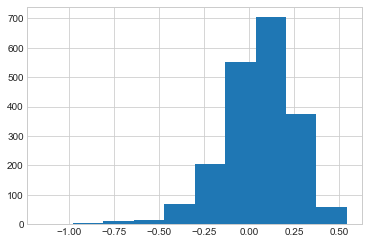

In [23]:
hist(scores);

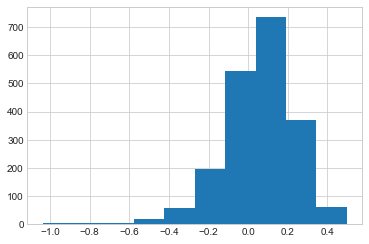

In [29]:
hist(stacking_scores);

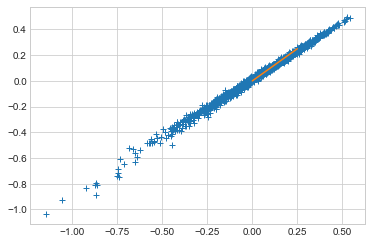

In [30]:
plot(scores, stacking_scores, '+');
plot(np.linspace(0, 0.25, 100), np.linspace(0, 0.25, 100))

In [40]:
stacking_scores

(array([ 0.08893442,  0.06424055,  0.19037547,  0.16908257,  0.01149917,
         0.08923947,  0.18221195,  0.1084338 ,  0.099719  ,  0.20107598,
         0.07944361,  0.0772034 ,  0.08532042,  0.15941857,  0.01965144,
         0.1224592 ,  0.11428732,  0.10029484,  0.16725438,  0.12921632,
         0.11845889,  0.20595628,  0.04685962,  0.18497557,  0.05632858,
         0.1601352 ,  0.19135915,  0.22413949,  0.16165855,  0.09543   ,
         0.11541282,  0.09080735,  0.063166  ,  0.08773563,  0.13248506,
         0.17134733,  0.22296261,  0.17039441,  0.04463414,  0.05756083,
         0.1621376 ,  0.12053197,  0.06487769,  0.16322449,  0.121751  ,
         0.06427964,  0.04436359,  0.19014761,  0.07460497,  0.15883903,
         0.04417429,  0.13700391,  0.15017152, -0.0369886 ,  0.1130116 ,
         0.14934408,  0.18089654,  0.11751153,  0.11570945,  0.12616662,
         0.20809374,  0.03922096,  0.09342908,  0.16778361,  0.18915567,
         0.09281156,  0.14319688,  0.09594235,  0.0

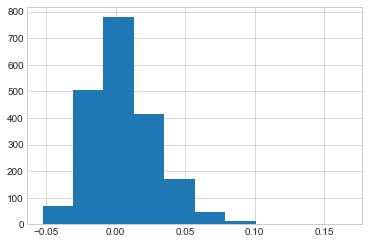

In [56]:
hist(stacking_scores - scores);

In [58]:
np.mean(stacking_scores - scores)

0.0054103687415666384

In [59]:
stacking_scores == scores

array([False, False, False, ..., False, False, False], dtype=bool)

In [60]:
from scipy import stats

In [62]:
stats.mannwhitneyu(stacking_scores, scores, alternative='greater')

MannwhitneyuResult(statistic=2015798.0, pvalue=0.33266058351262134)

In [71]:
stacking_prd.steps[1][1].coef_

user_id_mean     0.870907
user_id_count   -0.000196
dtype: float64

In [72]:
prd

Pipeline(memory=None,
     steps=[('scoresaggregator', ScoresAggregator()), ('linearregression', Adapter[LinearRegression](copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [73]:
prd.steps[1][1]

Adapter[LinearRegression](copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)